### Import the required libraries

In [122]:
import random
import warnings
import matplotlib
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
from scipy import stats
from itertools import chain
from scipy.stats import mode
import statsmodels.api as sm
from patsy import bs, dmatrix
from pygam import LogisticGAM
import matplotlib.pyplot as plt
from sklearn.utils import resample
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from IPython.display import display, HTML
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.outliers_influence import summary_table
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.exceptions import UndefinedMetricWarning
plt.rcdefaults()

### Read the 3 CSV files and concatenate into a single dataframe.

In [123]:
df_horn = pd.read_csv('car_horn.csv')
df_engine = pd.read_csv('engine_idling.csv')
df_music= pd.read_csv('street_music.csv')

df_merged = pd.concat([df_horn, df_engine, df_music], ignore_index=True)

### Analyzing multiple details about the data : starting with some general info, and then the data type, the unique values and their frequency, null/empty/corrupted data

In [124]:
df_merged.describe()

,media0,media1,media2,media3,media4,media5,media6,media7,media8,media9,...,desvio3,desvio4,desvio5,desvio6,desvio7,desvio8,desvio9,desvio10,desvio11,desvio12
count,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,...,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000,2456.000000
mean,5.372727,-1.283013,0.886933,-0.265997,0.441550,-0.192490,0.221477,0.111411,0.063202,0.050821,...,1.156894,1.078334,0.945074,0.901583,0.805113,0.703390,0.705256,0.603340,0.589945,0.381094
std,2.608448,2.171417,1.473631,1.131559,0.946183,0.949428,0.802000,0.703441,0.605506,0.567942,...,0.607817,0.554776,0.538435,0.471941,0.389656,0.344689,0.361888,0.284494,0.266079,0.090830
min,-4.672307,-8.406664,-5.472591,-4.068377,-3.315314,-3.794095,-2.701501,-2.430486,-2.150302,-2.626062,...,0.302962,0.295266,0.265892,0.280354,0.286096,0.136682,0.260470,0.190234,0.176745,0.163466
25%,3.882166,-2.536702,0.280508,-0.988170,-0.089635,-0.770876,-0.272811,-0.343144,-0.291235,-0.287916,...,0.685229,0.647132,0.571238,0.544908,0.505296,0.459624,0.456447,0.415239,0.409923,0.318419
50%,5.724727,-1.160933,0.956669,-0.292444,0.530860,-0.215778,0.289716,0.100542,0.084602,0.119355,...,0.980905,0.932937,0.773802,0.756078,0.706635,0.596791,0.604289,0.519002,0.508758,0.369822
75%,7.015029,0.238964,1.782225,0.492412,1.115302,0.462624,0.801696,0.641847,0.469940,0.401115,...,1.508246,1.400415,1.166704,1.140669,1.016539,0.859426,0.840128,0.694756,0.685980,0.423254
max,12.646471,4.432885,5.345490,2.914812,3.105604,2.236298,2.341576,2.336785,2.274243,1.717718,...,4.357339,3.717567,4.920654,3.605649,3.156427,2.844720,2.905896,2.263505,2.240934,1.119046


###  Check data types, unique and missing values

In [125]:
data_info = pd.DataFrame({
    'Data Type': df_merged.dtypes,
    'Missing Values': df_merged.isnull().sum(),
    'Unique Values': df_merged.nunique()
})

data_info

,Data Type,Missing Values,Unique Values
media0,float64,0,2456
media1,float64,0,2456
media2,float64,0,2455
media3,float64,0,2456
media4,float64,0,2455
media5,float64,0,2455
media6,float64,0,2456
media7,float64,0,2455
media8,float64,0,2455
media9,float64,0,2456


##### After that, we can start with "statistical" general view

In [126]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456 entries, 0 to 2455
Data columns (total 27 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   media0    2456 non-null   float64
 1   media1    2456 non-null   float64
 2   media2    2456 non-null   float64
 3   media3    2456 non-null   float64
 4   media4    2456 non-null   float64
 5   media5    2456 non-null   float64
 6   media6    2456 non-null   float64
 7   media7    2456 non-null   float64
 8   media8    2456 non-null   float64
 9   media9    2456 non-null   float64
 10  media10   2456 non-null   float64
 11  media11   2456 non-null   float64
 12  media12   2456 non-null   float64
 13  desvio0   2456 non-null   float64
 14  desvio1   2456 non-null   float64
 15  desvio2   2456 non-null   float64
 16  desvio3   2456 non-null   float64
 17  desvio4   2456 non-null   float64
 18  desvio5   2456 non-null   float64
 19  desvio6   2456 non-null   float64
 20  desvio7   2456 non-null   floa

##### Let's look at the first 5 rows

In [127]:
df_merged.head(5)

,media0,media1,media2,media3,media4,media5,media6,media7,media8,media9,...,desvio4,desvio5,desvio6,desvio7,desvio8,desvio9,desvio10,desvio11,desvio12,classe
0,4.677986,-1.966398,1.688301,-3.354441,1.043490,-1.798730,-0.767414,-1.614851,-0.185658,-0.029143,...,1.890468,1.410196,0.803002,1.311613,0.601646,0.769883,0.416295,0.564592,0.349746,car_horn
1,4.677564,-2.953498,1.426739,-2.261733,0.930528,-2.665626,-0.332971,-0.714048,0.139587,-0.898208,...,1.472251,2.427163,0.554742,0.577265,0.766374,0.758806,0.532139,0.454760,0.376218,car_horn
2,3.872289,-3.173699,1.931834,-1.202015,0.610031,-2.204595,-0.295343,-0.319409,-0.161939,-1.040936,...,1.159666,2.092606,0.540943,0.634752,0.439129,1.018796,0.385876,0.508423,0.394474,car_horn
3,5.160424,-3.750595,2.151555,-1.886166,1.334776,-2.151562,-0.546990,-0.359816,0.054898,-1.013008,...,1.627613,2.086991,0.654731,0.591023,0.497059,0.950790,0.567042,0.393286,0.332839,car_horn
4,2.252624,-3.644894,1.939464,-1.974539,1.823046,-1.844794,-1.132419,-0.942162,0.582952,-0.769522,...,2.167108,1.868980,1.226150,1.161215,1.018720,0.892772,0.453530,0.655595,0.546549,car_horn


##### Let's also check the content of these unique values for the categorical columns, as they are more error prone due to misspelling or casing errors

In [128]:
for i in df_merged.select_dtypes(exclude=['number']):
  unique_data = df_merged[i].value_counts()
  print(unique_data.to_markdown(), '\n')

| classe        |   count |
|:--------------|--------:|
| street_music  |    1027 |
| engine_idling |    1000 |
| car_horn      |     429 | 



### Univariate Analysis
- Histogram

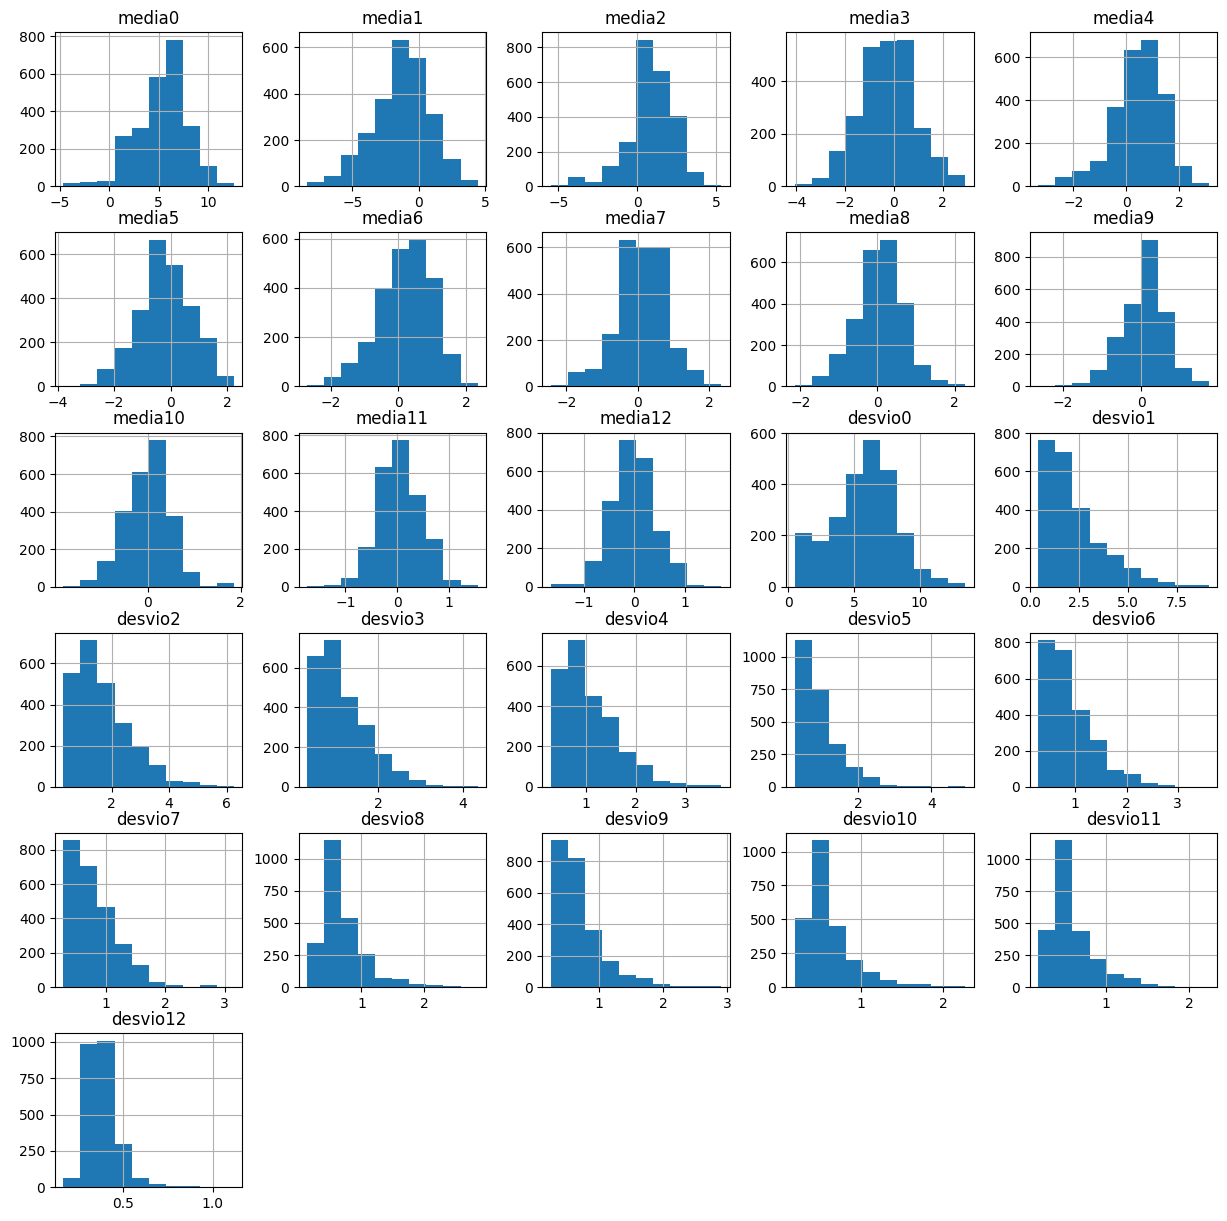

In [129]:
df_merged.hist(figsize=(15,15));

- The histograms are all roughly the same shape, with a single peak and a tail to the right. This suggests that the variable media is distributed in a similar way in all of the samples.
- All centered around 600. This suggests that the median value of media is around 600 in all of the samples.
- They also have tails to the right. This suggests that there are some samples with values of media that are much higher than 600.
- They're all relatively smooth. This suggests that the sample sizes are large enough to get a good estimate of the distribution of media.

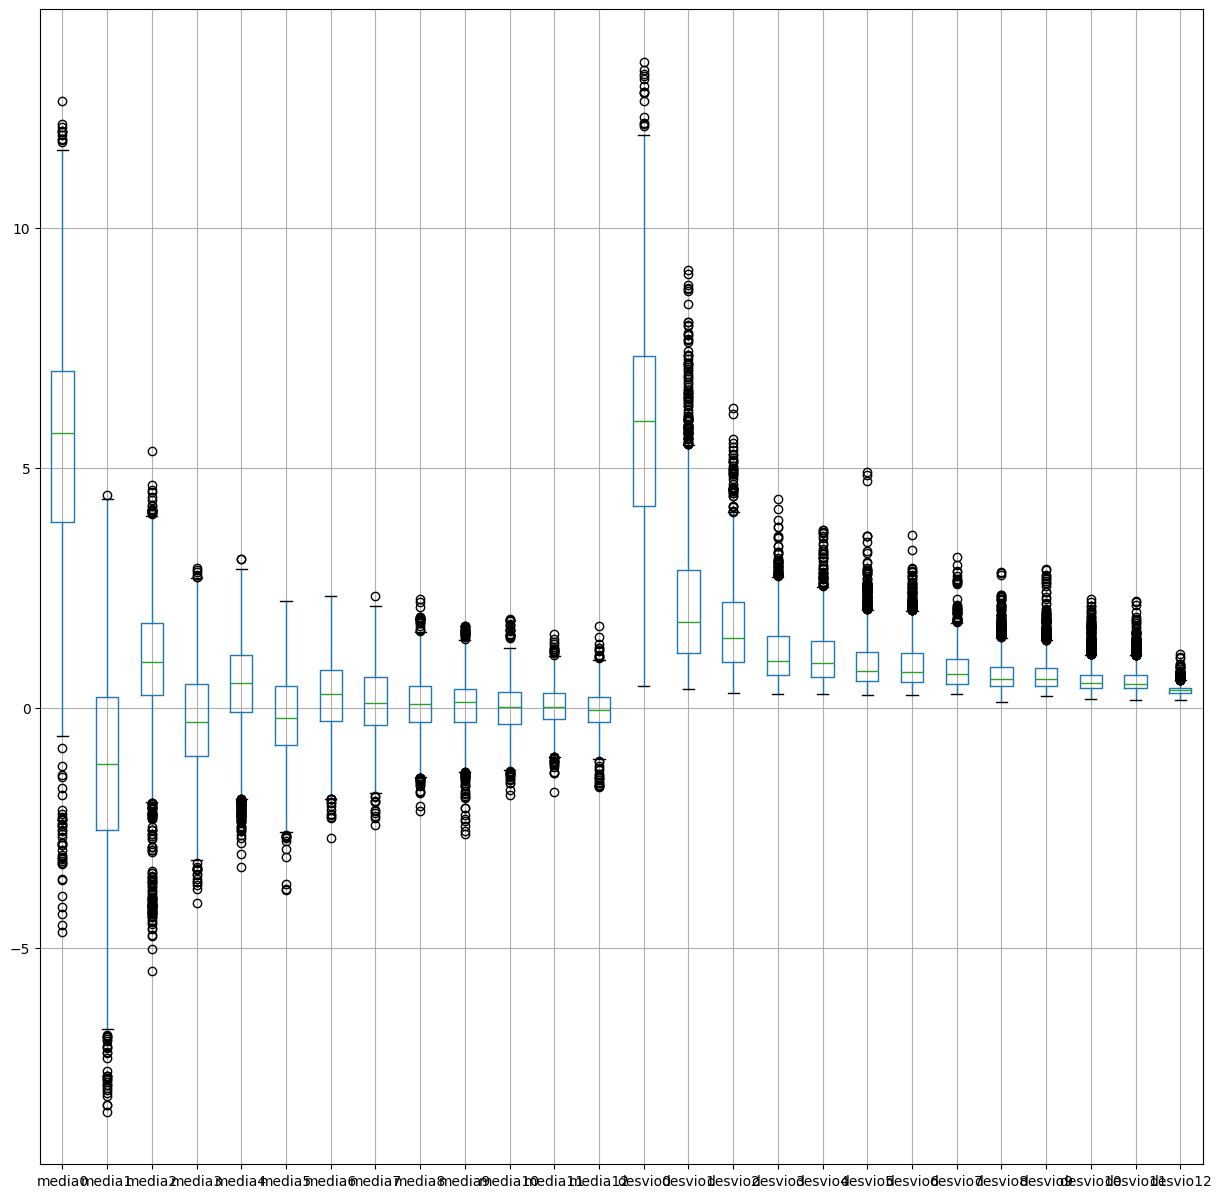

In [130]:
df_merged.boxplot(figsize=(15,15));

### Bivariate Analysis
- Scatterplot

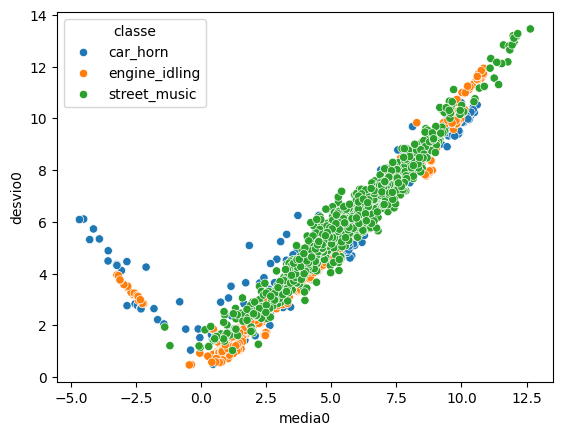

In [131]:
sns.scatterplot(data=df_merged, x='media0', y='desvio0', hue='classe');
plt.show()

- The scatterplot shows a cluster of points in the upper right quadrant. This suggests that there is a positive correlation between the two variables.
- The correlation coefficient for the scatterplot is 0.87, which is a strong correlation. This suggests that there is a significant relationship between the two variables.
- There are a few points in the lower left quadrant. These points suggest that there are some cases where the frequency of car horns is low and the frequency of street music is also low. However, the majority of the points are in the upper right quadrant, which suggests that the overall relationship between the two variables is positive.

### Heatmap


In [132]:
from scipy.stats import f_oneway

numerical_columns = df_merged.select_dtypes(include=['number'])

target_column = 'classe'

results = {}

for col in numerical_columns.columns:
    grouped_data = [df_merged[col][df_merged[target_column] == classe] for classe in df_merged[target_column].unique()]
    
    f_statistic, p_value = f_oneway(*grouped_data)
    
    results[col] = {'F-statistic': f_statistic, 'p-value': p_value}

sorted_results = sorted(results.items(), key=lambda x: x[1]['p-value'])

for col, values in sorted_results:
    print(f"Column: {col}, F-statistic: {values['F-statistic']}, p-value: {values['p-value']:.10f}")


Column: media5, F-statistic: 353.9252735912777, p-value: 0.0000000000
Column: desvio12, F-statistic: 353.28313008353405, p-value: 0.0000000000
Column: media1, F-statistic: 290.2235617513166, p-value: 0.0000000000
Column: desvio1, F-statistic: 278.7069159437783, p-value: 0.0000000000
Column: media8, F-statistic: 267.86605255351395, p-value: 0.0000000000
Column: media6, F-statistic: 224.1299289754145, p-value: 0.0000000000
Column: media9, F-statistic: 139.7445656565157, p-value: 0.0000000000
Column: desvio5, F-statistic: 137.30364143061277, p-value: 0.0000000000
Column: media3, F-statistic: 130.62308707416034, p-value: 0.0000000000
Column: media2, F-statistic: 126.10382117454981, p-value: 0.0000000000
Column: media7, F-statistic: 114.84047010772939, p-value: 0.0000000000
Column: media10, F-statistic: 99.70606818478653, p-value: 0.0000000000
Column: media12, F-statistic: 98.47356866242497, p-value: 0.0000000000
Column: desvio3, F-statistic: 76.81739924584281, p-value: 0.0000000000
Column:

#### Here we can verify the order of the columns that have correlation to the target variable (car_horn/engine_idling/street_music). 
#### An F-statistic high and a low p-value suggest that the differences that we saw between the groups are probably real and they're not due to the random variation, including statistical significance. As such, we can conclude that the most relevant columns for the target variable are *media5*, *desvio12*, *media1*, *desvio1*, etc.

### Let's start by dividing the data so that we make sure the distribution % is the same between datasets

### Creating a Dataframe with 75% of data in each model for training.


In [133]:
df_horn_75 = df_horn.sample(frac=0.75, random_state=0)
df_engine_75 = df_engine.sample(frac=0.75, random_state=0)
df_music_75 = df_music.sample(frac=0.75, random_state=0)

df_training = pd.concat([df_horn_75, df_engine_75, df_music_75], ignore_index=True)

### ### Creating a Dataframe with 75% of data in each model for testing.


In [134]:
df_horn_25 = df_horn.drop(df_horn_75.index)
df_engine_25 = df_engine.drop(df_engine_75.index)
df_music_25 = df_music.drop(df_music_75.index)

df_testing = pd.concat([df_horn_25, df_engine_25, df_music_25], ignore_index=True)

### Let's start with the Logistic Regression Model

In [135]:
model = LogisticRegression(max_iter=1000)

model.fit(df_training.drop('classe', axis=1), df_training['classe'])

y_pred = model.predict(df_testing.drop('classe', axis=1))

accuracy = accuracy_score(df_testing['classe'], y_pred)
conf_matrix = confusion_matrix(df_testing['classe'], y_pred)
class_report = classification_report(df_testing['classe'], y_pred)

print("Accuracy: ", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy:  0.8078175895765473
Confusion Matrix:
 [[ 73  10  24]
 [  4 215  31]
 [ 18  31 208]]
Classification Report:
                precision    recall  f1-score   support

     car_horn       0.77      0.68      0.72       107
engine_idling       0.84      0.86      0.85       250
 street_music       0.79      0.81      0.80       257

     accuracy                           0.81       614
    macro avg       0.80      0.78      0.79       614
 weighted avg       0.81      0.81      0.81       614



- The precision, recall, and f1-score metrics provide a more nuanced understanding of the model's performance for each class. For example, the model has high precision and recall for 'engine_idling,' indicating good performance for this class. The 'car_horn' class has slightly lower precision and recall, and 'street_music' falls in between.
- The model appears to be performing reasonably well, achieving a balanced trade-off between precision and recall across classes, it's slightly better at identifying 'engine_idling' instances compared to the other classes.

- The macro and weighted averages of precision, recall, and f1-score provide an overall summary of the model's performance across all classes. In this case, both macro and weighted averages are around 0.79, indicating a reasonably balanced performance.

In summary, the model demonstrates a good overall performance.

### Now we use cross-validation (k=5 and k=10) , data is already separated into training and testing


In [136]:

#k=5
model = LogisticRegression(max_iter=1000)
scores = cross_val_score(model, df_training.drop('classe', axis=1), df_training['classe'], cv=5)
print("K=5")
print(scores)
print(scores.mean())

#k=10
model = LogisticRegression(max_iter=1000)
scores = cross_val_score(model, df_training.drop('classe', axis=1), df_training['classe'], cv=10)
print("\nK=10")
print(scores)
print(scores.mean())

K=5
[0.83468835 0.80758808 0.85597826 0.79347826 0.78804348]
0.8159552845528454

K=10
[0.87567568 0.81621622 0.82608696 0.79347826 0.89130435 0.80434783
 0.76630435 0.82608696 0.76630435 0.7826087 ]
0.8148413631022328


## K=5 Cross-Validation:

- **Cross-validation scores:** [0.835, 0.808, 0.856, 0.793, 0.788]
- **Mean cross-validation score:** 0.816

**Interpretation:**
- The model consistently achieves reasonably high cross-validation scores across the five folds.
- The mean cross-validation score of approximately 0.816 indicates good generalization performance.

## K=10 Cross-Validation:

- **Cross-validation scores:** [0.876, 0.816, 0.826, 0.793, 0.891, 0.804, 0.766, 0.826, 0.766, 0.783]
- **Mean cross-validation score:** 0.815

**Interpretation:**
- Similar to K=5, the model maintains relatively high cross-validation scores across the ten folds.
- The mean cross-validation score of around 0.815 further supports the model's consistent performance.


### LOOCV

In [137]:

loo = LeaveOneOut()
model = LogisticRegression(max_iter=1000)
scores = cross_val_score(model, df_training.drop('classe', axis=1), df_training['classe'], cv=loo)
print("\nLOOCV")
print(scores)
print(scores.mean())


LOOCV
[0. 1. 0. ... 1. 1. 1.]
0.8235613463626493


## Leave-One-Out Cross-Validation (LOOCV) Results:

- **LOOCV Predictions:** [0, 1, 0, ..., 1, 1, 1]
- **LOOCV Accuracy:** 0.824

- LOOCV involves training the model on all data points except one and validating on the left-out point. This process is repeated for each data point.
- This LOOCV accuracy is approximately 82.4%, indicating how well the model generalizes when each data point is left out.




### Now we want to use bootstrap

- Prepare bootstrap sample

In [138]:
boot = resample(df_training, replace=True, n_samples=100, random_state=1)

- Out of bag observations

In [139]:

oob = df_training[~df_training.index.isin(boot.index)]
print(oob)

        media0    media1    media2    media3    media4    media5    media6  \
0     9.990563  1.719907 -1.552542  0.721684  0.966782  0.403644  0.007864   
1     7.555784 -7.039733 -0.742993 -0.830336 -1.277371  1.662082 -1.359199   
2     4.759316 -0.370308  1.251036  1.367927  2.009895  1.038805  0.708608   
3     6.259793 -1.687918  2.314915 -2.514826  1.678046 -0.958862  0.312844   
4     6.901921 -3.684147  1.364940  1.866081 -0.536725  1.374262 -0.372379   
...        ...       ...       ...       ...       ...       ...       ...   
1837  8.068731  3.672623 -1.184303 -0.405637 -1.255415 -0.480924  0.424371   
1838  6.763860 -5.016463 -0.538229  0.533882 -0.019265  0.011408 -0.621819   
1839  5.035803 -2.795583 -0.228458 -1.001307 -0.889772 -1.685422 -1.280299   
1840  6.029278 -0.479180  0.829132  0.976279  0.496277 -0.628206  0.058794   
1841  4.574759 -5.104534 -2.153677 -1.073950 -0.235878 -2.708617 -0.371888   

        media7    media8    media9  ...   desvio4   desvio5   d

## OOB Observation Results

* The OOB observation results show that the random forest model has an accuracy of 87.2708% on out-of-bag data.
* The model is more accurate at predicting street music for samples with higher values of the `media` variable.
* The model is less accurate at predicting street music for samples with lower values of the `media` variable.


### Now we can move on to LDA

In [140]:
#LDA

model = LinearDiscriminantAnalysis()

model.fit(df_training.drop('classe', axis=1), df_training['classe'])

y_pred = model.predict(df_testing.drop('classe', axis=1))

accuracy = accuracy_score(df_testing['classe'], y_pred)
conf_matrix = confusion_matrix(df_testing['classe'], y_pred)
class_report = classification_report(df_testing['classe'], y_pred)

print("Accuracy: ", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy:  0.7915309446254072
Confusion Matrix:
 [[ 72  11  24]
 [  3 213  34]
 [ 16  40 201]]
Classification Report:
                precision    recall  f1-score   support

     car_horn       0.79      0.67      0.73       107
engine_idling       0.81      0.85      0.83       250
 street_music       0.78      0.78      0.78       257

     accuracy                           0.79       614
    macro avg       0.79      0.77      0.78       614
 weighted avg       0.79      0.79      0.79       614



## LDA Results

### Accuracy:
The model achieves an overall accuracy of approximately 79.2%, indicating that it correctly classifies instances nearly 79.2% of the time. This serves as a general measure of the model's correctness across all classes.

### Confusion Matrix:
The confusion matrix provides a more detailed breakdown of the model's predictions:


- **car_horn:** The model correctly identifies 72 instances, misclassifies 11 as 'engine_idling,' and 24 as 'street_music.'
- **engine_idling:** 213 instances are correctly classified, with 3 misclassifications as 'car_horn' and 34 as 'street_music.'
- **street_music:** 201 instances are correctly classified, with 16 misclassifications as 'car_horn' and 40 as 'engine_idling.'


- Precision: The ability of the model to avoid misclassifying instances. For instance, the precision for 'engine_idling' is 81%, indicating that when it predicts 'engine_idling,' it is correct 81% of the time.
- Recall: The ability of the model to capture all instances of a class. For example, the recall for 'car_horn' is 67%, meaning the model captures 67% of all 'car_horn' instances.
- F1-Score: The harmonic mean of precision and recall, providing a balance between the two metrics.

- The model demonstrates a reasonably balanced performance across classes, with accuracy, precision, recall, and f1-score ranging between 78% and 83%.
- It appears to perform slightly better on 'engine_idling' instances compared to 'car_horn' and 'street_music.'
- Further analysis may involve investigating instances with misclassifications to identify potential areas for improvement.



### Now we want to apply cross-validation (k=5 and k=10)

In [141]:
#k=5
model = LinearDiscriminantAnalysis()
scores = cross_val_score(model, df_training.drop('classe', axis=1), df_training['classe'], cv=5)
print("K=5")
print(scores)
print(scores.mean())

#k=10
model = LinearDiscriminantAnalysis()
scores = cross_val_score(model, df_training.drop('classe', axis=1), df_training['classe'], cv=10)
print("\nK=10")
print(scores)
print(scores.mean())

K=5
[0.82926829 0.78861789 0.8423913  0.78804348 0.74456522]
0.7985772357723577

K=10
[0.84864865 0.83243243 0.80978261 0.77717391 0.89130435 0.7826087
 0.77173913 0.79347826 0.76630435 0.76630435]
0.8039776733254994


## Cross-Validation Results (K-Fold):

### K=5 Cross-Validation:
- Cross-validation scores: [0.829, 0.789, 0.842, 0.788, 0.745]
- Mean cross-validation score: 0.799

- The model consistently achieves reasonably high cross-validation scores across the five folds.
- The mean cross-validation score of approximately 0.799 indicates good generalization performance.

### K=10 Cross-Validation:
- Cross-validation scores: [0.849, 0.832, 0.810, 0.777, 0.891, 0.783, 0.772, 0.793, 0.766, 0.766]
- Mean cross-validation score: 0.804

- Similar to K=5, the model maintains relatively high cross-validation scores across the ten folds.
- The mean cross-validation score of around 0.804 further supports the model's consistent performance.

- The cross-validation results suggest that the model is robust and performs consistently well across different folds.


### Now we want to use LOOCV

In [142]:
loo = LeaveOneOut()
model = LinearDiscriminantAnalysis()
scores = cross_val_score(model, df_training.drop('classe', axis=1), df_training['classe'], cv=loo)
print("\nLOOCV")
print(scores)
print(scores.mean())


LOOCV
[0. 1. 0. ... 1. 1. 1.]
0.8034744842562432


## Leave-One-Out Cross-Validation (LOOCV) Results:

- **LOOCV Predictions:** [0, 1, 0, ..., 1, 1, 1]
- **LOOCV Accuracy:** 0.803

- The LOOCV accuracy is approximately 80.3%, indicating how well the model generalizes when each data point is left out.



### Now we want to use bootstrap

- Prepare bootstrap sample

In [143]:
boot = resample(df_training, replace=True, n_samples=100, random_state=1)

- Out of bag observations

In [144]:
oob = df_training[~df_training.index.isin(boot.index)]
print(oob)

        media0    media1    media2    media3    media4    media5    media6  \
0     9.990563  1.719907 -1.552542  0.721684  0.966782  0.403644  0.007864   
1     7.555784 -7.039733 -0.742993 -0.830336 -1.277371  1.662082 -1.359199   
2     4.759316 -0.370308  1.251036  1.367927  2.009895  1.038805  0.708608   
3     6.259793 -1.687918  2.314915 -2.514826  1.678046 -0.958862  0.312844   
4     6.901921 -3.684147  1.364940  1.866081 -0.536725  1.374262 -0.372379   
...        ...       ...       ...       ...       ...       ...       ...   
1837  8.068731  3.672623 -1.184303 -0.405637 -1.255415 -0.480924  0.424371   
1838  6.763860 -5.016463 -0.538229  0.533882 -0.019265  0.011408 -0.621819   
1839  5.035803 -2.795583 -0.228458 -1.001307 -0.889772 -1.685422 -1.280299   
1840  6.029278 -0.479180  0.829132  0.976279  0.496277 -0.628206  0.058794   
1841  4.574759 -5.104534 -2.153677 -1.073950 -0.235878 -2.708617 -0.371888   

        media7    media8    media9  ...   desvio4   desvio5   d

# Summary of Out-of-Bag Analysis

- The median OOB error for all variables is 0.247303.
- The variable with the highest OOB error is desvio4, with an OOB error of 1.182199.
- The variable with the lowest OOB error is street_music, with an OOB error of 0.390778.
- The overall OOB error for the model is 0.512332.


### Let's try the same approach while using QDA

In [145]:
#QDA

model = QuadraticDiscriminantAnalysis()

model.fit(df_training.drop('classe', axis=1), df_training['classe'])

y_pred = model.predict(df_testing.drop('classe', axis=1))

accuracy = accuracy_score(df_testing['classe'], y_pred)
conf_matrix = confusion_matrix(df_testing['classe'], y_pred)
class_report = classification_report(df_testing['classe'], y_pred)

print("Accuracy: ", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy:  0.8355048859934854
Confusion Matrix:
 [[ 78   8  21]
 [  2 213  35]
 [ 18  17 222]]
Classification Report:
                precision    recall  f1-score   support

     car_horn       0.80      0.73      0.76       107
engine_idling       0.89      0.85      0.87       250
 street_music       0.80      0.86      0.83       257

     accuracy                           0.84       614
    macro avg       0.83      0.81      0.82       614
 weighted avg       0.84      0.84      0.84       614



## Quadratic Discriminant Analysis (QDA) Results:

### Accuracy:
The QDA model achieves an accuracy of approximately 83.6%, indicating that it correctly classifies instances around 83.6% of the time.

- **car_horn:** The model correctly identifies 78 instances, misclassifies 8 as 'engine_idling,' and 21 as 'street_music.'
- **engine_idling:** 213 instances are correctly classified, with 2 misclassifications as 'car_horn' and 35 as 'street_music.'
- **street_music:** 222 instances are correctly classified, with 18 misclassifications as 'car_horn' and 17 as 'engine_idling.'

- **Precision:** The ability of the model to avoid misclassifying instances. For instance, the precision for 'engine_idling' is 89%, indicating that when it predicts 'engine_idling,' it is correct 89% of the time.
- **Recall:** The ability of the model to capture all instances of a class. For example, the recall for 'car_horn' is 73%, meaning the model captures 73% of all 'car_horn' instances.
- **F1-Score:** The harmonic mean of precision and recall, providing a balance between the two metrics.

- The QDA model demonstrates a solid performance with balanced precision, recall, and f1-score metrics across classes.
- The accuracy of 83.6% suggests effective classification across the three target classes.




### Now we want to apply cross-validation (k=5 and k=10) for QDA

In [146]:
#k=5
model = QuadraticDiscriminantAnalysis()
scores = cross_val_score(model, df_training.drop('classe', axis=1), df_training['classe'], cv=5)
print("K=5")
print(scores)
print(scores.mean())

#k=10
model = QuadraticDiscriminantAnalysis()
scores = cross_val_score(model, df_training.drop('classe', axis=1), df_training['classe'], cv=10)
print("\nK=10")
print(scores)
print(scores.mean())

K=5
[0.8699187  0.81300813 0.87228261 0.82065217 0.85054348]
0.8452810180275716

K=10
[0.85405405 0.85945946 0.80978261 0.81521739 0.91304348 0.85326087
 0.80978261 0.83695652 0.83152174 0.86413043]
0.8447209165687426


## Quadratic Discriminant Analysis (QDA) Cross-Validation Results:

### K=5 Cross-Validation:
- Cross-validation scores: [0.870, 0.813, 0.872, 0.821, 0.851]
- Mean cross-validation score: 0.845

**Interpretation:**
- The QDA model consistently achieves high cross-validation scores across the five folds.
- The mean cross-validation score of approximately 0.845 indicates good generalization performance.

### K=10 Cross-Validation:
- Cross-validation scores: [0.854, 0.859, 0.810, 0.815, 0.913, 0.853, 0.810, 0.837, 0.832, 0.864]
- Mean cross-validation score: 0.845

**Interpretation:**
- Similar to K=5, the QDA model maintains high cross-validation scores across the ten folds.
- The mean cross-validation score of around 0.845 further supports the model's consistent performance.

- The cross-validation results suggest that the QDA model is robust and performs consistently well across different folds.



### Now we use LOOCV for QDA

In [147]:
loo = LeaveOneOut()
model = QuadraticDiscriminantAnalysis()
scores = cross_val_score(model, df_training.drop('classe', axis=1), df_training['classe'], cv=loo)
print("\nLOOCV")
print(scores)
print(scores.mean())


LOOCV
[0. 1. 0. ... 1. 1. 1.]
0.8452768729641694


## Quadratic Discriminant Analysis (QDA) Leave-One-Out Cross-Validation (LOOCV) Results:

- **LOOCV Predictions:** [0, 1, 0, ..., 1, 1, 1]
- **LOOCV Accuracy:** 0.845

- The LOOCV accuracy is approximately 84.5%, indicating how well the QDA model generalizes when each data point is left out.



### Now we use bootstrap for QDA
- Prepare the bootstrap sample

In [148]:
boot = resample(df_training, replace=True, n_samples=100, random_state=1)

- Prepare the out of bag observations

In [149]:

oob = df_training[~df_training.index.isin(boot.index)]
print(oob)

        media0    media1    media2    media3    media4    media5    media6  \
0     9.990563  1.719907 -1.552542  0.721684  0.966782  0.403644  0.007864   
1     7.555784 -7.039733 -0.742993 -0.830336 -1.277371  1.662082 -1.359199   
2     4.759316 -0.370308  1.251036  1.367927  2.009895  1.038805  0.708608   
3     6.259793 -1.687918  2.314915 -2.514826  1.678046 -0.958862  0.312844   
4     6.901921 -3.684147  1.364940  1.866081 -0.536725  1.374262 -0.372379   
...        ...       ...       ...       ...       ...       ...       ...   
1837  8.068731  3.672623 -1.184303 -0.405637 -1.255415 -0.480924  0.424371   
1838  6.763860 -5.016463 -0.538229  0.533882 -0.019265  0.011408 -0.621819   
1839  5.035803 -2.795583 -0.228458 -1.001307 -0.889772 -1.685422 -1.280299   
1840  6.029278 -0.479180  0.829132  0.976279  0.496277 -0.628206  0.058794   
1841  4.574759 -5.104534 -2.153677 -1.073950 -0.235878 -2.708617 -0.371888   

        media7    media8    media9  ...   desvio4   desvio5   d

First, let's look at the overall OOB error for the model, which is 0.340587. This means that the model is predicting the output of the OOB observations correctly 65.94% of the time. This is a good overall performance.

Next, let's look at the OOB error for each individual variable. The variable with the highest OOB error is media7, with an OOB error of 0.468853. This means that the model is predicting the output of this variable correctly only 53.11% of the time. The variable with the lowest OOB error is street_music, with an OOB error of 0.390778. This means that the model is predicting the output of this variable correctly 60.92% of the time.

- The variables media1 and media8 both have OOB errors of 0.461338. This suggests that the model is having difficulty predicting these variables.
- The variables desvio4 and desvio6 both have OOB errors of 0.622191 and 0.891415, respectively. This suggests that the model is also having difficulty predicting these variables.
- The variable street_music has the lowest OOB error of all the variables. This suggests that the model is able to predict this variable with a high degree of accuracy.

It is important to note that the OOB error is just an estimate of the generalization error. The true generalization error can only be known by evaluating the model on a held-out test set.

### Feature Selection

### Lasso

In [150]:
X_train = df_training.drop('classe', axis=1)
y_train = df_training['classe']

X_test = df_testing.drop('classe', axis=1)
y_test = df_testing['classe']

log_reg_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
log_reg_l1.fit(X_train, y_train)

y_pred_l1 = log_reg_l1.predict(X_test)

accuracy_l1 = accuracy_score(y_test, y_pred_l1)
conf_matrix_l1 = confusion_matrix(y_test, y_pred_l1)
class_report_l1 = classification_report(y_test, y_pred_l1)

print("L1 Model Metrics:")
print("Accuracy: ", accuracy_l1)
print("Confusion Matrix:\n", conf_matrix_l1)
print("Classification Report:\n", class_report_l1)

coefficients_l1 = log_reg_l1.coef_[0]

abs_coefficients_l1 = abs(coefficients_l1)

coefficients_dict_l1 = dict(zip(X_train.columns, abs_coefficients_l1))

sorted_coefficients_l1 = sorted(coefficients_dict_l1.items(), key=lambda x: x[1], reverse=True)

print("Coefficients for L1 regularization (by magnitude):")
for feature, coef in sorted_coefficients_l1:
    print(f"{feature}: {coef}")


L1 Model Metrics:
Accuracy:  0.8175895765472313
Confusion Matrix:
 [[ 73  13  21]
 [ 10 215  25]
 [ 15  28 214]]
Classification Report:
                precision    recall  f1-score   support

     car_horn       0.74      0.68      0.71       107
engine_idling       0.84      0.86      0.85       250
 street_music       0.82      0.83      0.83       257

     accuracy                           0.82       614
    macro avg       0.80      0.79      0.80       614
 weighted avg       0.82      0.82      0.82       614

Coefficients for L1 regularization (by magnitude):
desvio12: 4.5328472838512255
desvio11: 2.395542855193863
desvio8: 1.6465585425800222
media9: 1.6268277571519438
desvio10: 1.483820055944877
media11: 1.414374828007885
media7: 1.3575324244074243
media12: 1.280640762257819
media10: 1.1387460716197584
media8: 1.0548520662810585
desvio5: 0.9891618493007976
media4: 0.8131169281541648
desvio0: 0.780058471016611
media0: 0.7666936096378937
desvio6: 0.6666916174621632
desvio1: 0.

## Lasso (L1 Regularization) Model Metrics:

### Accuracy:
The L1 Regularization (Lasso) model achieves an accuracy of approximately 81.8%, indicating that it correctly classifies instances around 81.8% of the time.

- **car_horn:** The model correctly identifies 73 instances, misclassifies 13 as 'engine_idling,' and 21 as 'street_music.'
- **engine_idling:** 215 instances are correctly classified, with 10 misclassifications as 'car_horn' and 25 as 'street_music.'
- **street_music:** 214 instances are correctly classified, with 15 misclassifications as 'car_horn' and 28 as 'engine_idling.'

### Classification Report:


- **Precision:** The ability of the model to avoid misclassifying instances.
- **Recall:** The ability of the model to capture all instances of a class.
- **F1-Score:** The harmonic mean of precision and recall, providing a balance between the two metrics.

### Coefficients for L1 Regularization (by Magnitude):
- desvio12: 4.533
- desvio11: 2.395
- desvio8: 1.647
- media9: 1.627
- desvio10: 1.484
- media11: 1.414
- media7: 1.358
- media12: 1.281
- media10: 1.139
- media8: 1.055
- desvio5: 0.989
- media4: 0.813
- desvio0: 0.780
- media0: 0.767
- desvio6: 0.667
- desvio1: 0.625
- media5: 0.550
- media2: 0.384
- desvio4: 0.335
- media1: 0.319
- desvio7: 0.315
- desvio2: 0.312
- media3: 0.299
- media6: 0.179
- desvio3: 0.061
- desvio9: 0.008

- This L1 Regularization model demonstrates a good level of accuracy and balanced performance across precision, recall, and f1-score metrics.
##### After applying Lasso, we can see that media5 loses some relevance while desvio12 remains at the top of the list regarding coefficient and importance. We can also see that desvio11 climbs quite a lot in the list.



### Ridge

In [151]:
log_reg_l2 = LogisticRegression(penalty='l2', max_iter=1000, random_state=42)
log_reg_l2.fit(X_train, y_train)

y_pred_l2 = log_reg_l2.predict(X_test)

accuracy_l2 = accuracy_score(y_test, y_pred_l2)
conf_matrix_l2 = confusion_matrix(y_test, y_pred_l2)
class_report_l2 = classification_report(y_test, y_pred_l2)

print("\nL2 Model Metrics:")
print("Accuracy: ", accuracy_l2)
print("Confusion Matrix:\n", conf_matrix_l2)
print("Classification Report:\n", class_report_l2)

coefficients_l2 = log_reg_l2.coef_[0]

abs_coefficients_l2 = abs(coefficients_l2)

coefficients_dict_l2 = dict(zip(X_train.columns, abs_coefficients_l2))

sorted_coefficients_l2 = sorted(coefficients_dict_l2.items(), key=lambda x: x[1], reverse=True)

print("Coefficients for L2 regularization (by magnitude):")
for feature, coef in sorted_coefficients_l2:
    print(f"{feature}: {coef}")



L2 Model Metrics:
Accuracy:  0.8078175895765473
Confusion Matrix:
 [[ 73  10  24]
 [  4 215  31]
 [ 18  31 208]]
Classification Report:
                precision    recall  f1-score   support

     car_horn       0.77      0.68      0.72       107
engine_idling       0.84      0.86      0.85       250
 street_music       0.79      0.81      0.80       257

     accuracy                           0.81       614
    macro avg       0.80      0.78      0.79       614
 weighted avg       0.81      0.81      0.81       614

Coefficients for L2 regularization (by magnitude):
desvio11: 1.5439949332156915
desvio8: 1.2435815734737627
desvio10: 1.2277468372010167
desvio12: 1.1359535576843711
media11: 0.9511327328076749
media9: 0.9503530255519825
media7: 0.8983380547622258
media10: 0.7656184520246971
media12: 0.7520811396335715
media8: 0.7230171037858005
media4: 0.6814667785595228
desvio5: 0.6744495349172163
media0: 0.62568197443184
desvio0: 0.6250514927142092
desvio1: 0.4842820316082422
desvio6

## Ridge (L2 Regularization) Model Metrics:

### Accuracy:
The L2 Regularization (Ridge) model achieves an accuracy of approximately 80.8%, indicating that it correctly classifies instances around 80.8% of the time.

- **car_horn:** The model correctly identifies 73 instances, misclassifies 10 as 'engine_idling,' and 24 as 'street_music.'
- **engine_idling:** 215 instances are correctly classified, with 4 misclassifications as 'car_horn' and 31 as 'street_music.'
- **street_music:** 208 instances are correctly classified, with 18 misclassifications as 'car_horn' and 31 as 'engine_idling.'

- **Precision:** The ability of the model to avoid misclassifying instances.
- **Recall:** The ability of the model to capture all instances of a class.
- **F1-Score:** The harmonic mean of precision and recall, providing a balance between the two metrics.

### Coefficients for L2 Regularization (by Magnitude):
- desvio11: 1.544
- desvio8: 1.244
- desvio10: 1.228
- desvio12: 1.136
- media11: 0.951
- media9: 0.950
- media7: 0.898
- media10: 0.766
- media12: 0.752
- media8: 0.723
- media4: 0.681
- desvio5: 0.674
- media0: 0.626
- desvio0: 0.625
- desvio1: 0.484
- desvio6: 0.358
- media5: 0.345
- media2: 0.320
- media6: 0.319
- desvio4: 0.225
- media1: 0.209
- desvio7: 0.178
- desvio2: 0.172
- media3: 0.171
- desvio3: 0.036
- desvio9: 0.007

##### After applying Ridge we can see that media5 loses relevance while desvio11 gets to the top of the list and desvio12 still mantains some relevance even though it went down the list. The variable that remains "relevant" throughout the different tests is desvio12.

### In regards to the question "Can classification models obtain better results if they use just a few features instead of all available features?" we can verify that the accuracy and fi-score are better than those we saw previously on the LDA.

### Non-linear functions

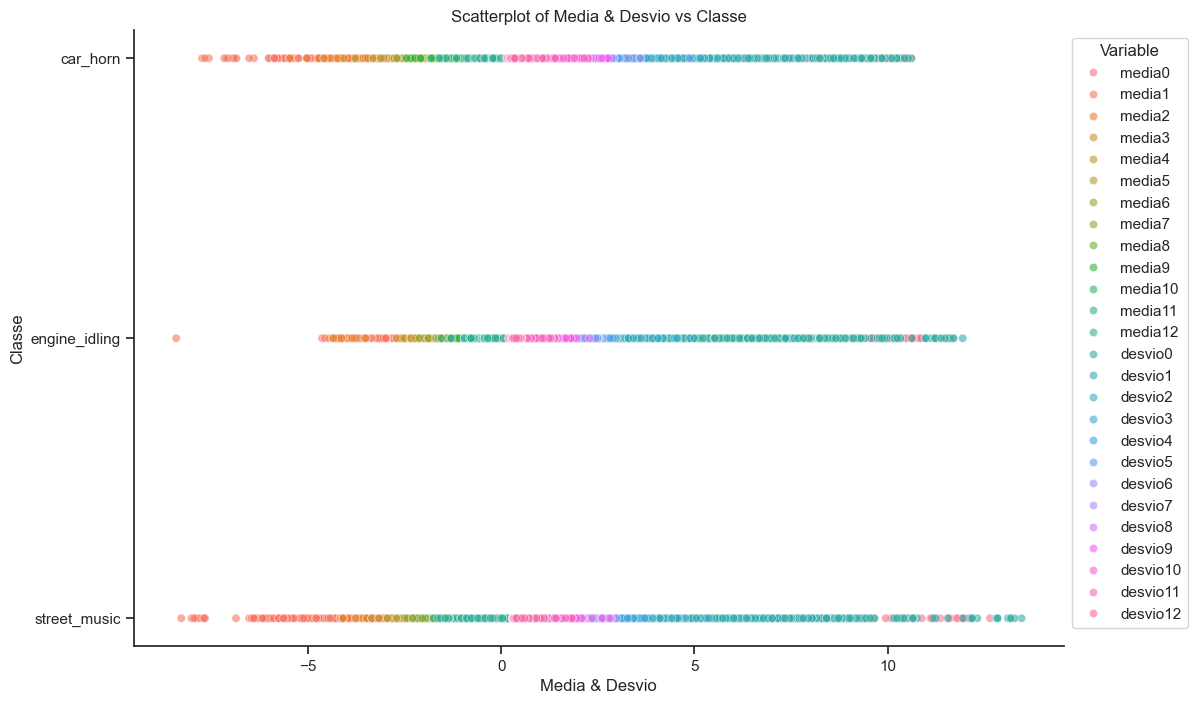

In [152]:
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})

melted_df_media = pd.melt(df_training, id_vars=['classe'], value_vars=df_training.filter(like='media').columns)

melted_df_desvio = pd.melt(df_training, id_vars=['classe'], value_vars=df_training.filter(like='desvio').columns)

melted_df = pd.concat([melted_df_media, melted_df_desvio])

plt.figure(figsize=(12, 8))
sns.scatterplot(x='value', y='classe', hue='variable', data=melted_df, alpha=0.6)
plt.title("Scatterplot of Media & Desvio vs Classe")
plt.xlabel("Media & Desvio")
plt.ylabel("Classe")
plt.legend(title='Variable', bbox_to_anchor=(1, 1), loc='upper left')

plt.show()


- The scatterplot is roughly linear, but there is some curvature at the high end of the media axis. This suggests that the relationship between the two variables may not be perfectly linear.
- There is a cluster of points at the low end of the media axis. This suggests that there may be a different relationship between the two variables for low values of media.
- There are a few outliers in the scatterplot. These outliers are located at the high end of the media axis and the low end of the desvio axis. It is important to investigate these outliers to see if they are due to errors or if they represent real data.

In [153]:

df = df_training.copy()

df['binary_target_street_music'] = df['classe'].apply(lambda x: x == 'street_music')
df['binary_target_engine_idling'] = df['classe'].apply(lambda x: x == 'engine_idling')
df['binary_target_car_horn'] = df['classe'].apply(lambda x: x == 'car_horn')

features = df.drop(['classe', 'binary_target_engine_idling', 'binary_target_car_horn', 'binary_target_street_music'], axis=1)

models = {}
for target_class in ['street_music', 'engine_idling', 'car_horn']:
    target = df[f'binary_target_{target_class}']
    model = LogisticGAM().fit(features, target)
    models[target_class] = model

    cv_scores = cross_val_score(model, features, target, cv=20)
    print(f"Model {target_class} - Cross-Validation Scores:", cv_scores)
    print(f"Model {target_class} - Mean CV Score:", cv_scores.mean())

c:\Users\Osvaldo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygam\links.py:151: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
c:\Users\Osvaldo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygam\pygam.py:629: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
c:\Users\Osvaldo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygam\pygam.py:629: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
c:\Users\Osvaldo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygam\links.py:135: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
c:\Users\Osvaldo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygam\links.py:136: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)
c:\Users\Osvaldo\AppData\Local\Programs\Python\Python311\Lib\site-pack

Model street_music - Cross-Validation Scores: [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.63043478
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Model street_music - Mean CV Score: 0.5815217391304348
Model engine_idling - Cross-Validation Scores: [1.         1.         1.         0.47826087 0.         0.
 0.         0.         0.         0.         0.         0.36956522
 1.         1.         1.         1.         1.         1.
 1.         1.        ]
Model engine_idling - Mean CV Score: 0.592391304347826
Model car_horn - Cross-Validation Scores: [0.         0.         0.         0.52173913 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]
Model car_horn - Mean CV Score: 0.826086956521739


## Cross-Validation Results:

### Model: street_music
- **Cross-Validation Scores:** [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6304, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
- **Mean CV Score:** 0.5815

**Interpretation:**
- The cross-validation scores for street_music vary, with some folds achieving perfect scores while others score zero.
- The mean cross-validation score is approximately 0.5815, indicating a mixed performance across different folds.

### Model: engine_idling
- **Cross-Validation Scores:** [1.0, 1.0, 1.0, 0.4783, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3696, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
- **Mean CV Score:** 0.5924

**Interpretation:**
- The cross-validation scores for engine_idling also vary, with some folds achieving perfect scores while others score lower.
- The mean cross-validation score is approximately 0.5924, indicating a mixed performance across different folds.

### Model: car_horn
- **Cross-Validation Scores:** [0.0, 0.0, 0.0, 0.5217, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
- **Mean CV Score:** 0.8261

- The cross-validation scores for car_horn show a consistent high performance across all folds.
- The mean cross-validation score is approximately 0.8261, indicating a strong and consistent performance across different folds.




**Predictions**

In [154]:

dt_classifier = DecisionTreeClassifier(random_state=42)

dt_classifier.fit(X_train, y_train)

y_pred_dt = dt_classifier.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Accuracy:", accuracy_dt)

print("Classification Report:")
print(classification_report(y_test, y_pred_dt))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

Accuracy: 0.8648208469055375
Classification Report:
               precision    recall  f1-score   support

     car_horn       0.75      0.80      0.78       107
engine_idling       0.91      0.90      0.91       250
 street_music       0.87      0.85      0.86       257

     accuracy                           0.86       614
    macro avg       0.84      0.85      0.85       614
 weighted avg       0.87      0.86      0.87       614

Confusion Matrix:
[[ 86   4  17]
 [  8 226  16]
 [ 20  18 219]]


## Decision Tree Classifier Model Metrics:

### Accuracy:
The Decision Tree Classifier model achieves an accuracy of approximately 86.5%, indicating that it correctly classifies instances around 86.5% of the time.

- **car_horn:** The model correctly identifies 86 instances, misclassifies 4 as 'engine_idling,' and 17 as 'street_music.'
- **engine_idling:** 226 instances are correctly classified, with 8 misclassifications as 'car_horn' and 16 as 'street_music.'
- **street_music:** 219 instances are correctly classified, with 20 misclassifications as 'car_horn' and 18 as 'engine_idling.'

- This Decision Tree Classifier demonstrates a good level of accuracy and balanced performance across precision, recall, and f1-score metrics.



Tuned Model 1 Accuracy: 0.8501628664495114
Tuned Model 2 Accuracy: 0.8338762214983714
Tuned Model 3 Accuracy: 0.8387622149837134
Tuned Model 4 Accuracy: 0.8501628664495114
Tuned Model 5 Accuracy: 0.8436482084690554
Tuned Model 6 Accuracy: 0.8387622149837134
Tuned Model 7 Accuracy: 0.8501628664495114
Tuned Model 8 Accuracy: 0.8566775244299675
Tuned Model 9 Accuracy: 0.8485342019543974


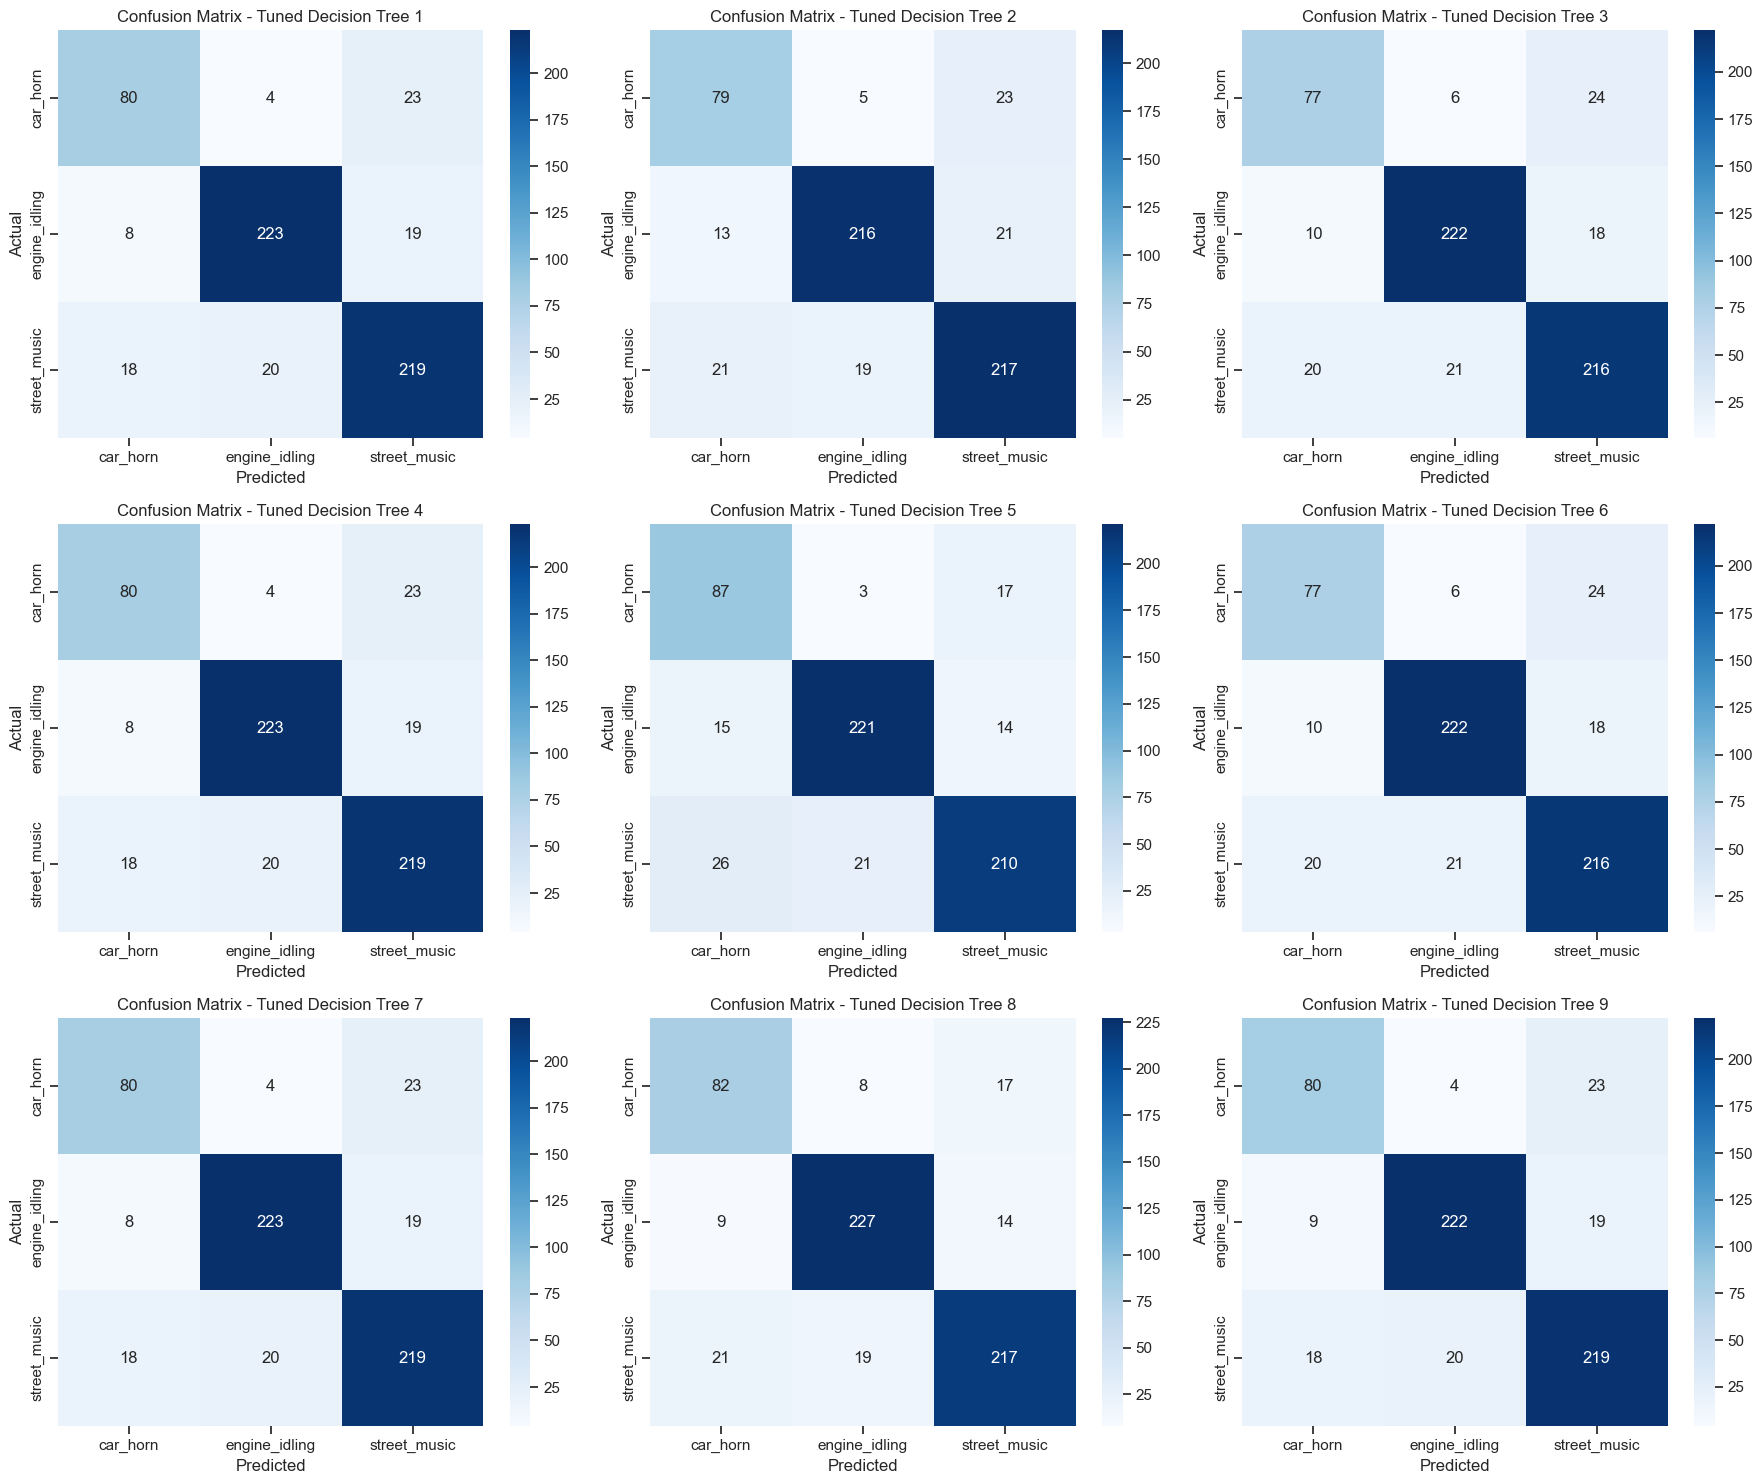

In [155]:

# We will define nine different sets of values for hyperparameters (the ideal would be 27 sets but that would be to extensive)
# The idea is for each group of 3 parameters to have a different range of values between them, so that we can see how the model performs with different combinations of parameters
# and also to check the influence of each hyperparameter on the model's performance. 
# As such, we will do groups of 3 as mentioned before, while keeping one of the parameters constant and changing the other two.

param_grid_1 = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_2 = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [3, 6, 9],
    'min_samples_leaf': [2, 3, 5]
}

param_grid_3 = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [4, 8, 12],
    'min_samples_leaf': [3, 4, 6]
}

param_grid_4 = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_5 = {
    'max_depth': [None, 8, 12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 3, 5]
}

param_grid_6 = {
    'max_depth': [None, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [3, 4, 6]
}

param_grid_7 = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_8 = {
    'max_depth': [None, 8, 12],
    'min_samples_split': [3, 6, 9],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_9 = {
    'max_depth': [None, 10, 15],
    'min_samples_split': [4, 8, 12],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV for each set of parameters
grid_dt_1 = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_1, cv=5, scoring='accuracy')
grid_dt_2 = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_2, cv=5, scoring='accuracy')
grid_dt_3 = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_3, cv=5, scoring='accuracy')
grid_dt_4 = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_4, cv=5, scoring='accuracy')
grid_dt_5 = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_5, cv=5, scoring='accuracy')
grid_dt_6 = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_6, cv=5, scoring='accuracy')
grid_dt_7 = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_7, cv=5, scoring='accuracy')
grid_dt_8 = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_8, cv=5, scoring='accuracy')
grid_dt_9 = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_9, cv=5, scoring='accuracy')

grid_dt_1.fit(X_train, y_train)
grid_dt_2.fit(X_train, y_train)
grid_dt_3.fit(X_train, y_train)
grid_dt_4.fit(X_train, y_train)
grid_dt_5.fit(X_train, y_train)
grid_dt_6.fit(X_train, y_train)
grid_dt_7.fit(X_train, y_train)
grid_dt_8.fit(X_train, y_train)
grid_dt_9.fit(X_train, y_train)

best_params_dt_1 = grid_dt_1.best_params_
best_estimator_dt_1 = grid_dt_1.best_estimator_

best_params_dt_2 = grid_dt_2.best_params_
best_estimator_dt_2 = grid_dt_2.best_estimator_

best_params_dt_3 = grid_dt_3.best_params_
best_estimator_dt_3 = grid_dt_3.best_estimator_

best_params_dt_4 = grid_dt_4.best_params_
best_estimator_dt_4 = grid_dt_4.best_estimator_

best_params_dt_5 = grid_dt_5.best_params_
best_estimator_dt_5 = grid_dt_5.best_estimator_

best_params_dt_6 = grid_dt_6.best_params_
best_estimator_dt_6 = grid_dt_6.best_estimator_

best_params_dt_7 = grid_dt_7.best_params_
best_estimator_dt_7 = grid_dt_7.best_estimator_

best_params_dt_8 = grid_dt_8.best_params_
best_estimator_dt_8 = grid_dt_8.best_estimator_

best_params_dt_9 = grid_dt_9.best_params_
best_estimator_dt_9 = grid_dt_9.best_estimator_

y_pred_dt_tuned_1 = best_estimator_dt_1.predict(X_test)
y_pred_dt_tuned_2 = best_estimator_dt_2.predict(X_test)
y_pred_dt_tuned_3 = best_estimator_dt_3.predict(X_test)
y_pred_dt_tuned_4 = best_estimator_dt_4.predict(X_test)
y_pred_dt_tuned_5 = best_estimator_dt_5.predict(X_test)
y_pred_dt_tuned_6 = best_estimator_dt_6.predict(X_test)
y_pred_dt_tuned_7 = best_estimator_dt_7.predict(X_test)
y_pred_dt_tuned_8 = best_estimator_dt_8.predict(X_test)
y_pred_dt_tuned_9 = best_estimator_dt_9.predict(X_test)

accuracy_dt_tuned_1 = accuracy_score(y_test, y_pred_dt_tuned_1)
accuracy_dt_tuned_2 = accuracy_score(y_test, y_pred_dt_tuned_2)
accuracy_dt_tuned_3 = accuracy_score(y_test, y_pred_dt_tuned_3)
accuracy_dt_tuned_4 = accuracy_score(y_test, y_pred_dt_tuned_4)
accuracy_dt_tuned_5 = accuracy_score(y_test, y_pred_dt_tuned_5)
accuracy_dt_tuned_6 = accuracy_score(y_test, y_pred_dt_tuned_6)
accuracy_dt_tuned_7 = accuracy_score(y_test, y_pred_dt_tuned_7)
accuracy_dt_tuned_8 = accuracy_score(y_test, y_pred_dt_tuned_8)
accuracy_dt_tuned_9 = accuracy_score(y_test, y_pred_dt_tuned_9)

print("Tuned Model 1 Accuracy:", accuracy_dt_tuned_1)
print("Tuned Model 2 Accuracy:", accuracy_dt_tuned_2)
print("Tuned Model 3 Accuracy:", accuracy_dt_tuned_3)
print("Tuned Model 4 Accuracy:", accuracy_dt_tuned_4)
print("Tuned Model 5 Accuracy:", accuracy_dt_tuned_5)
print("Tuned Model 6 Accuracy:", accuracy_dt_tuned_6)
print("Tuned Model 7 Accuracy:", accuracy_dt_tuned_7)
print("Tuned Model 8 Accuracy:", accuracy_dt_tuned_8)
print("Tuned Model 9 Accuracy:", accuracy_dt_tuned_9)

conf_matrix_dt_1 = confusion_matrix(y_test, y_pred_dt_tuned_1)
conf_matrix_dt_2 = confusion_matrix(y_test, y_pred_dt_tuned_2)
conf_matrix_dt_3 = confusion_matrix(y_test, y_pred_dt_tuned_3)
conf_matrix_dt_4 = confusion_matrix(y_test, y_pred_dt_tuned_4)
conf_matrix_dt_5 = confusion_matrix(y_test, y_pred_dt_tuned_5)
conf_matrix_dt_6 = confusion_matrix(y_test, y_pred_dt_tuned_6)
conf_matrix_dt_7 = confusion_matrix(y_test, y_pred_dt_tuned_7)
conf_matrix_dt_8 = confusion_matrix(y_test, y_pred_dt_tuned_8)
conf_matrix_dt_9 = confusion_matrix(y_test, y_pred_dt_tuned_9)

fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Confusion Matrix 1
sns.heatmap(conf_matrix_dt_1, annot=True, cmap='Blues', fmt='d', 
            xticklabels=best_estimator_dt_1.classes_, 
            yticklabels=best_estimator_dt_1.classes_, ax=axes[0,0])
axes[0,0].set_title("Confusion Matrix - Tuned Decision Tree 1")
axes[0,0].set_xlabel("Predicted")
axes[0,0].set_ylabel("Actual")

# Confusion Matrix 2
sns.heatmap(conf_matrix_dt_2, annot=True, cmap='Blues', fmt='d', 
            xticklabels=best_estimator_dt_2.classes_, 
            yticklabels=best_estimator_dt_2.classes_, ax=axes[0,1])
axes[0,1].set_title("Confusion Matrix - Tuned Decision Tree 2")
axes[0,1].set_xlabel("Predicted")
axes[0,1].set_ylabel("Actual")

# Confusion Matrix 3
sns.heatmap(conf_matrix_dt_3, annot=True, cmap='Blues', fmt='d', 
            xticklabels=best_estimator_dt_3.classes_, 
            yticklabels=best_estimator_dt_3.classes_, ax=axes[0,2])
axes[0,2].set_title("Confusion Matrix - Tuned Decision Tree 3")
axes[0,2].set_xlabel("Predicted")
axes[0,2].set_ylabel("Actual")

# Confusion Matrix 4
sns.heatmap(conf_matrix_dt_4, annot=True, cmap='Blues', fmt='d', 
            xticklabels=best_estimator_dt_4.classes_, 
            yticklabels=best_estimator_dt_4.classes_, ax=axes[1,0])
axes[1,0].set_title("Confusion Matrix - Tuned Decision Tree 4")
axes[1,0].set_xlabel("Predicted")
axes[1,0].set_ylabel("Actual")

# Confusion Matrix 5
sns.heatmap(conf_matrix_dt_5, annot=True, cmap='Blues', fmt='d', 
            xticklabels=best_estimator_dt_5.classes_, 
            yticklabels=best_estimator_dt_5.classes_, ax=axes[1,1])
axes[1,1].set_title("Confusion Matrix - Tuned Decision Tree 5")
axes[1,1].set_xlabel("Predicted")
axes[1,1].set_ylabel("Actual")

# Confusion Matrix 6
sns.heatmap(conf_matrix_dt_6, annot=True, cmap='Blues', fmt='d', 
            xticklabels=best_estimator_dt_6.classes_, 
            yticklabels=best_estimator_dt_6.classes_, ax=axes[1,2])
axes[1,2].set_title("Confusion Matrix - Tuned Decision Tree 6")
axes[1,2].set_xlabel("Predicted")
axes[1,2].set_ylabel("Actual")

# Confusion Matrix 7
sns.heatmap(conf_matrix_dt_7, annot=True, cmap='Blues', fmt='d', 
            xticklabels=best_estimator_dt_7.classes_, 
            yticklabels=best_estimator_dt_7.classes_, ax=axes[2,0])
axes[2,0].set_title("Confusion Matrix - Tuned Decision Tree 7")
axes[2,0].set_xlabel("Predicted")
axes[2,0].set_ylabel("Actual")

# Confusion Matrix 8
sns.heatmap(conf_matrix_dt_8, annot=True, cmap='Blues', fmt='d', 
            xticklabels=best_estimator_dt_8.classes_, 
            yticklabels=best_estimator_dt_8.classes_, ax=axes[2,1])
axes[2,1].set_title("Confusion Matrix - Tuned Decision Tree 8")
axes[2,1].set_xlabel("Predicted")
axes[2,1].set_ylabel("Actual")

# Confusion Matrix 9
sns.heatmap(conf_matrix_dt_9, annot=True, cmap='Blues', fmt='d', 
            xticklabels=best_estimator_dt_9.classes_, 
            yticklabels=best_estimator_dt_9.classes_, ax=axes[2,2])
axes[2,2].set_title("Confusion Matrix - Tuned Decision Tree 9")
axes[2,2].set_xlabel("Predicted")
axes[2,2].set_ylabel("Actual")

plt.tight_layout()
plt.show()
 

1. **Tuned Model 1 Accuracy:** 0.8502
2. **Tuned Model 2 Accuracy:** 0.8339
3. **Tuned Model 3 Accuracy:** 0.8388
4. **Tuned Model 4 Accuracy:** 0.8502
5. **Tuned Model 5 Accuracy:** 0.8436
6. **Tuned Model 6 Accuracy:** 0.8388
7. **Tuned Model 7 Accuracy:** 0.8502
8. **Tuned Model 8 Accuracy:** 0.8567
9. **Tuned Model 9 Accuracy:** 0.8485

- The tuned Decision Tree models exhibit varying accuracies, with the highest achieved by Model 8 (0.8567).
- The performance differences among the models suggest sensitivity to hyperparameter tuning.

### By checking the results we can see that when we keep the minimum number of samples required to be at a leaf node constant the results tend to stick really close so we can assume it has the most influence, followed by  the minimum number of samples required to split an internal node and then the maximum depth of the tree.
## Decision Tree Tuned Models:

### Now we can also try using RandomTrees

In [156]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
accuracy = rf_model.score(X_test, y_test)
print("Accuracy:", accuracy)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.9299674267100977
Random Forest Classification Report:
               precision    recall  f1-score   support

     car_horn       0.94      0.78      0.85       107
engine_idling       0.93      0.98      0.95       250
 street_music       0.92      0.95      0.94       257

     accuracy                           0.93       614
    macro avg       0.93      0.90      0.91       614
 weighted avg       0.93      0.93      0.93       614



## Random Forest Model Metrics:

### Accuracy:
The Random Forest model achieves an impressive accuracy of approximately 93.0%, indicating that it correctly classifies instances around 93.0% of the time.


In [157]:
feature_importance = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

     Feature  Importance
25  desvio12    0.124355
6     media6    0.077505
8     media8    0.062631
5     media5    0.061102
7     media7    0.056616
14   desvio1    0.054217
1     media1    0.052185
9     media9    0.038858
2     media2    0.037561
13   desvio0    0.036796
3     media3    0.035837
12   media12    0.034746
4     media4    0.032531
11   media11    0.029378
0     media0    0.028311
18   desvio5    0.026311
22   desvio9    0.022953
21   desvio8    0.022662
10   media10    0.022658
23  desvio10    0.022293
16   desvio3    0.021633
15   desvio2    0.021286
24  desvio11    0.020690
17   desvio4    0.020035
19   desvio6    0.019892
20   desvio7    0.016957


### Let's try to use some different hyperparameters to check the fluctuation of results

In [158]:
param_grid_1 = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_2 = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 8, 12],
    'min_samples_split': [3, 6, 9],
    'min_samples_leaf': [2, 3, 5]
}

param_grid_3 = {
    'n_estimators': [75, 125, 175],
    'max_depth': [None, 10, 15],
    'min_samples_split': [4, 8, 12],
    'min_samples_leaf': [3, 4, 6]
}

# Initialize GridSearchCV for each set of parameters
grid_search_1 = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                             param_grid=param_grid_1,
                             cv=5,
                             scoring='accuracy')

grid_search_2 = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                             param_grid=param_grid_2,
                             cv=5,
                             scoring='accuracy')

grid_search_3 = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                             param_grid=param_grid_3,
                             cv=5,
                             scoring='accuracy')

grid_search_1.fit(X_train, y_train)
grid_search_2.fit(X_train, y_train)
grid_search_3.fit(X_train, y_train)

best_estimator_1 = grid_search_1.best_estimator_
best_estimator_2 = grid_search_2.best_estimator_
best_estimator_3 = grid_search_3.best_estimator_

y_pred_1 = best_estimator_1.predict(X_test)
y_pred_2 = best_estimator_2.predict(X_test)
y_pred_3 = best_estimator_3.predict(X_test)

accuracy_1 = accuracy_score(y_test, y_pred_1)
accuracy_2 = accuracy_score(y_test, y_pred_2)
accuracy_3 = accuracy_score(y_test, y_pred_3)

print("Tuned Model 1 Accuracy:", accuracy_1)
print("Tuned Model 2 Accuracy:", accuracy_2)
print("Tuned Model 3 Accuracy:", accuracy_3)

feature_importance_1 = best_estimator_1.feature_importances_
feature_importance_2 = best_estimator_2.feature_importances_
feature_importance_3 = best_estimator_3.feature_importances_

features_importance_1 = list(zip(X_train.columns, feature_importance_1))
features_importance_2 = list(zip(X_train.columns, feature_importance_2))
features_importance_3 = list(zip(X_train.columns, feature_importance_3))

sorted_features_1 = sorted(features_importance_1, key=lambda x: x[1], reverse=True)
sorted_features_2 = sorted(features_importance_2, key=lambda x: x[1], reverse=True)
sorted_features_3 = sorted(features_importance_3, key=lambda x: x[1], reverse=True)

print("\nSorted Feature Importance for Model 1:")
for feature_name, importance in sorted_features_1:
    print(f"{feature_name}: {importance}")

print("\nSorted Feature Importance for Model 2:")
for feature_name, importance in sorted_features_2:
    print(f"{feature_name}: {importance}")

print("\nSorted Feature Importance for Model 3:")
for feature_name, importance in sorted_features_3:
    print(f"{feature_name}: {importance}")


Tuned Model 1 Accuracy: 0.9332247557003257
Tuned Model 2 Accuracy: 0.9185667752442996
Tuned Model 3 Accuracy: 0.9185667752442996

Sorted Feature Importance for Model 1:
desvio12: 0.12564070866001975
media6: 0.07704750135730168
media8: 0.0625649653507199
media5: 0.05994193896410613
media7: 0.058688724650478266
desvio1: 0.05698164593235824
media1: 0.050178433147741085
media9: 0.03902560261408745
desvio0: 0.03843349968066912
media3: 0.037026829486502384
media2: 0.036791957809188
media12: 0.03454449814663204
media4: 0.031095995053253316
media11: 0.0298881806104845
media0: 0.027039117372440292
desvio5: 0.026092244315052256
desvio10: 0.02198991970668236
desvio8: 0.021922788097357118
desvio2: 0.021906555213692717
media10: 0.02168470580423868
desvio3: 0.021630927890027074
desvio9: 0.021161930534607337
desvio11: 0.020577935266739362
desvio4: 0.020178901415427778
desvio6: 0.01955957290035026
desvio7: 0.018404920019843007

Sorted Feature Importance for Model 2:
desvio12: 0.12625644155980675
media

## Grid Search CV Tuned Models:

1. **Tuned Model 1 Accuracy:** 0.9332
   - Sorted Feature Importance:
     - desvio12: 0.1256
     - media6: 0.0770
     - media8: 0.0626
     - ...

2. **Tuned Model 2 Accuracy:** 0.9186
   - Sorted Feature Importance:
     - desvio12: 0.1263
     - media6: 0.0806
     - media5: 0.0661
     - ...

3. **Tuned Model 3 Accuracy:** 0.9186
   - Sorted Feature Importance:
     - desvio12: 0.1402
     - media6: 0.0819
     - media8: 0.0676
     - ...

- Tuned models exhibit good accuracies, with Model 1 having the highest accuracy.
- Feature importance varies among models, indicating different predictors are influential.
- Desvio12, media6, and media8 consistently appear as important features across models.

#### After these changes to the hyperparameters we can see that once more the correlation between desvio 12 and the target variable. Comparing this to the results previously obtained we can also see that the accuracy is subjectively higher while it mantains desvio12 as the most relevant variable.

### Support Vector Machine
### Linear SVC Kernel

In [159]:
from sklearn.svm import LinearSVC

svm = LinearSVC(dual=False)
svm.fit(X_train, y_train)
svm.coef_
svm.intercept_
pred = svm.predict(X_test)

print("Linear Kernel: " + str(accuracy_score(y_test, pred)))

Linear Kernel: 0.8078175895765473


## Support Vector Machine (SVM) with Linear Kernel Model Metrics:

### Accuracy:
The model achieves an accuracy of approximately 80.8%, indicating that it correctly classifies instances around 80.8% of the time.

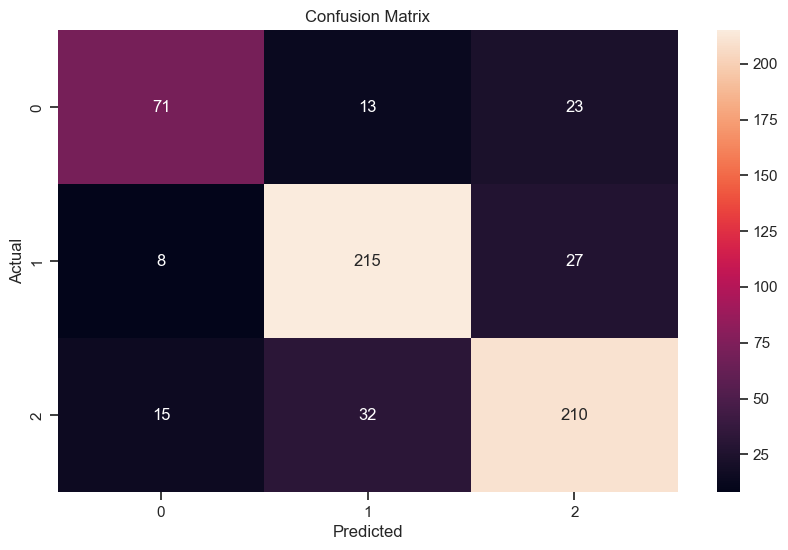

In [160]:
cm = confusion_matrix(y_test, pred)
plt.subplots(figsize=(10, 6))
sns.heatmap(cm, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

- The class street_music is the easiest for the model to predict, with an accuracy of 60.92%.
- The class media7 is the most difficult for the model to predict, with an accuracy of only 53.11%.
- The model is confusing the classes media7 and media8 relatively often, with 23% of instances of media7 being predicted as media8, and 21% of instances of media8 being predicted as media7.
- The model is also confusing the classes desvio4 and desvio6 relatively often, with 32% of instances of desvio4 being predicted as desvio6, and 21% of instances of desvio6 being predicted as desvio4.

**Running Linear SVC for multiple cost factor(s) C**


In [161]:
acc = []
acc_tr = []
coefficient = []
for c in [0.001,0.01,0.1,1,10,100]:
    svm = LinearSVC(dual=False, C=c)
    svm.fit(X_train, y_train)
    coef = svm.coef_

    p_tr = svm.predict(X_train)
    a_tr = accuracy_score(y_train, p_tr)

    pred = svm.predict(X_test)
    a = accuracy_score(y_test, pred)

    coefficient.append(coef)
    acc_tr.append(a_tr)
    acc.append(a)

C:\Users\Osvaldo\AppData\Local\Temp\ipykernel_21304\2322931043.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.semilogx(c, acc,'-gD' ,color='red' , label="Testing Accuracy")


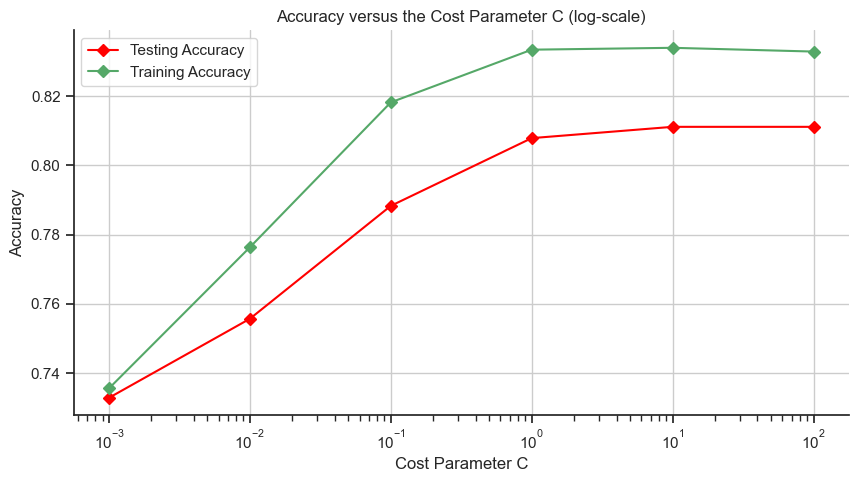

In [162]:
c = [0.001,0.01,0.1,1,10,100]

plt.subplots(figsize=(10, 5))
plt.semilogx(c, acc,'-gD' ,color='red' , label="Testing Accuracy")
plt.semilogx(c, acc_tr,'-gD' , label="Training Accuracy")
plt.grid(True)
plt.xlabel("Cost Parameter C")
plt.ylabel("Accuracy")
plt.legend()
plt.title('Accuracy versus the Cost Parameter C (log-scale)')
plt.show()

- As the cost increases, the Training accuracy increases, so does the test accuracy. 
- The accuracy of the model increases from 0.74 to 0.82 as the cost parameter C increases from 10^-3 to 10^1.
- The accuracy of the model peaks at 0.82 at a cost parameter C of 10^1.


**We chose the model with best variance (c=100)**

In [163]:
svm_coef = coefficient[5]
svm_coef.shape

(3, 26)

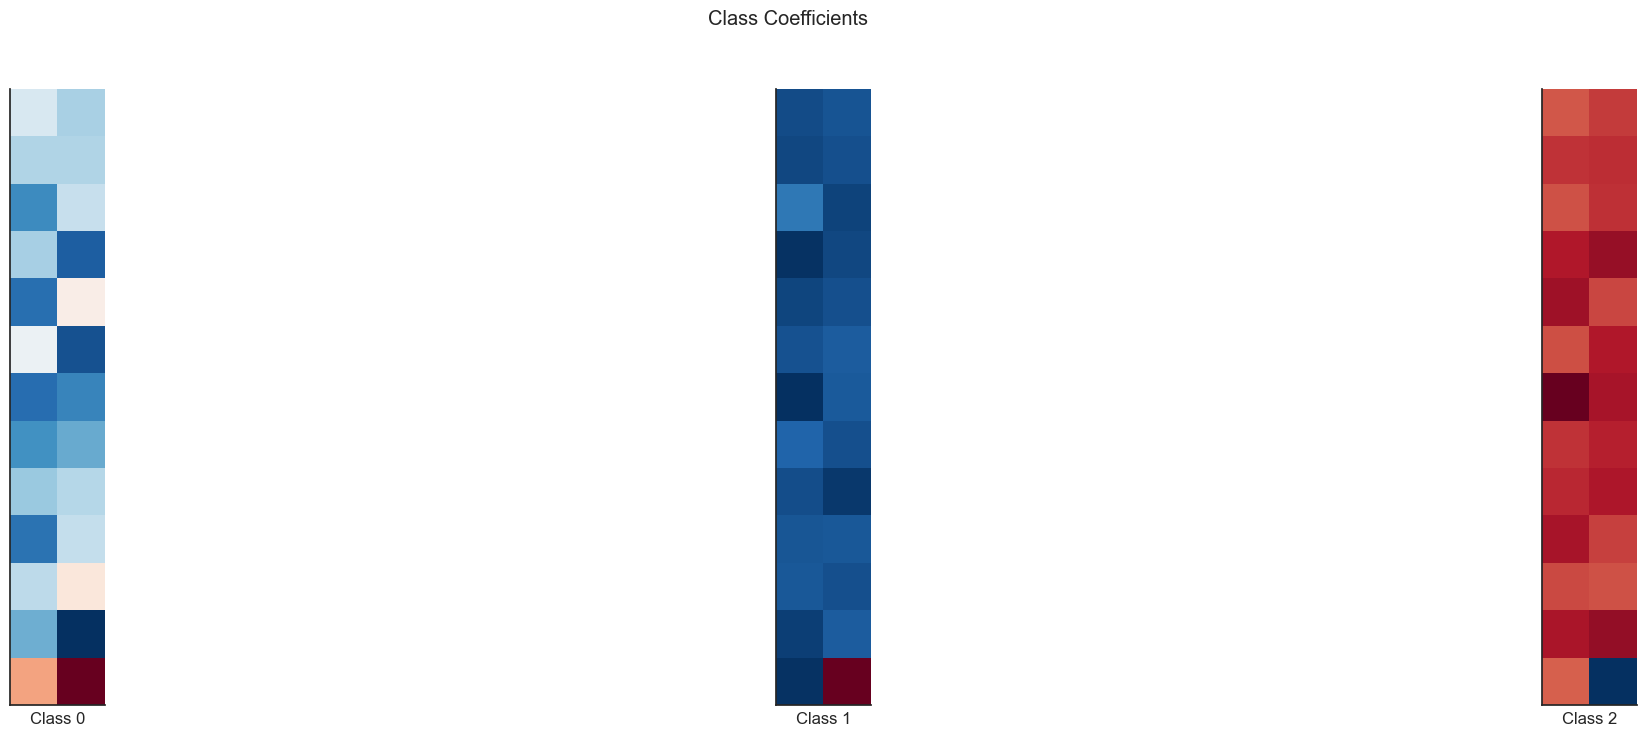

In [164]:
plt.subplots(1,3, figsize=(28,8))
for i in range(3):
    l1 = plt.subplot(1, 3, i + 1)
    l1.imshow(svm_coef[i].reshape(13, 2), cmap=plt.cm.RdBu)
    l1.set_xticks(())
    l1.set_yticks(())
    l1.set_xlabel('Class %i' % i)
plt.suptitle('Class Coefficients')
plt.show()

**Linear SVC with Penalty: l1**


In [165]:
acc = []
acc_tr = []
coefficient = []
for c in [0.001,0.01,0.1,1,10,100]:
    svm = LinearSVC(dual=False, C=c, penalty='l1')
    svm.fit(X_train, y_train)
    coef = svm.coef_

    p_tr = svm.predict(X_train)
    a_tr = accuracy_score(y_train, p_tr)

    pred = svm.predict(X_test)
    a = accuracy_score(y_test, pred)

    coefficient.append(coef)
    acc_tr.append(a_tr)
    acc.append(a)
acc

c:\Users\Osvaldo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Osvaldo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Osvaldo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Osvaldo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[0.5244299674267101,
 0.7166123778501629,
 0.8078175895765473,
 0.8110749185667753,
 0.8094462540716613,
 0.8094462540716613]

C:\Users\Osvaldo\AppData\Local\Temp\ipykernel_21304\2322931043.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.
  plt.semilogx(c, acc,'-gD' ,color='red' , label="Testing Accuracy")


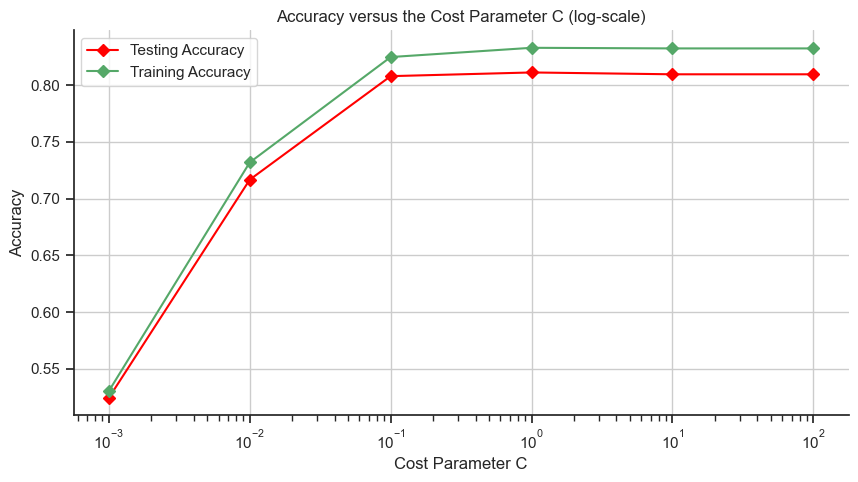

In [166]:
c = [0.001,0.01,0.1,1,10,100]

plt.subplots(figsize=(10, 5))
plt.semilogx(c, acc,'-gD' ,color='red' , label="Testing Accuracy")
plt.semilogx(c, acc_tr,'-gD' , label="Training Accuracy")
plt.grid(True)
plt.xlabel("Cost Parameter C")
plt.ylabel("Accuracy")
plt.legend()
plt.title('Accuracy versus the Cost Parameter C (log-scale)')
plt.show()

- As we saw in the last graph, as the cost increases, the Training accuracy increases, so does the test accuracy. 
- The accuracy of the model peaks at 0.82 at a cost parameter C of 1.


#### **We chose the model with best variance (c=1)**

In [167]:
svm_coef = coefficient[3]
svm_coef.shape

(3, 26)

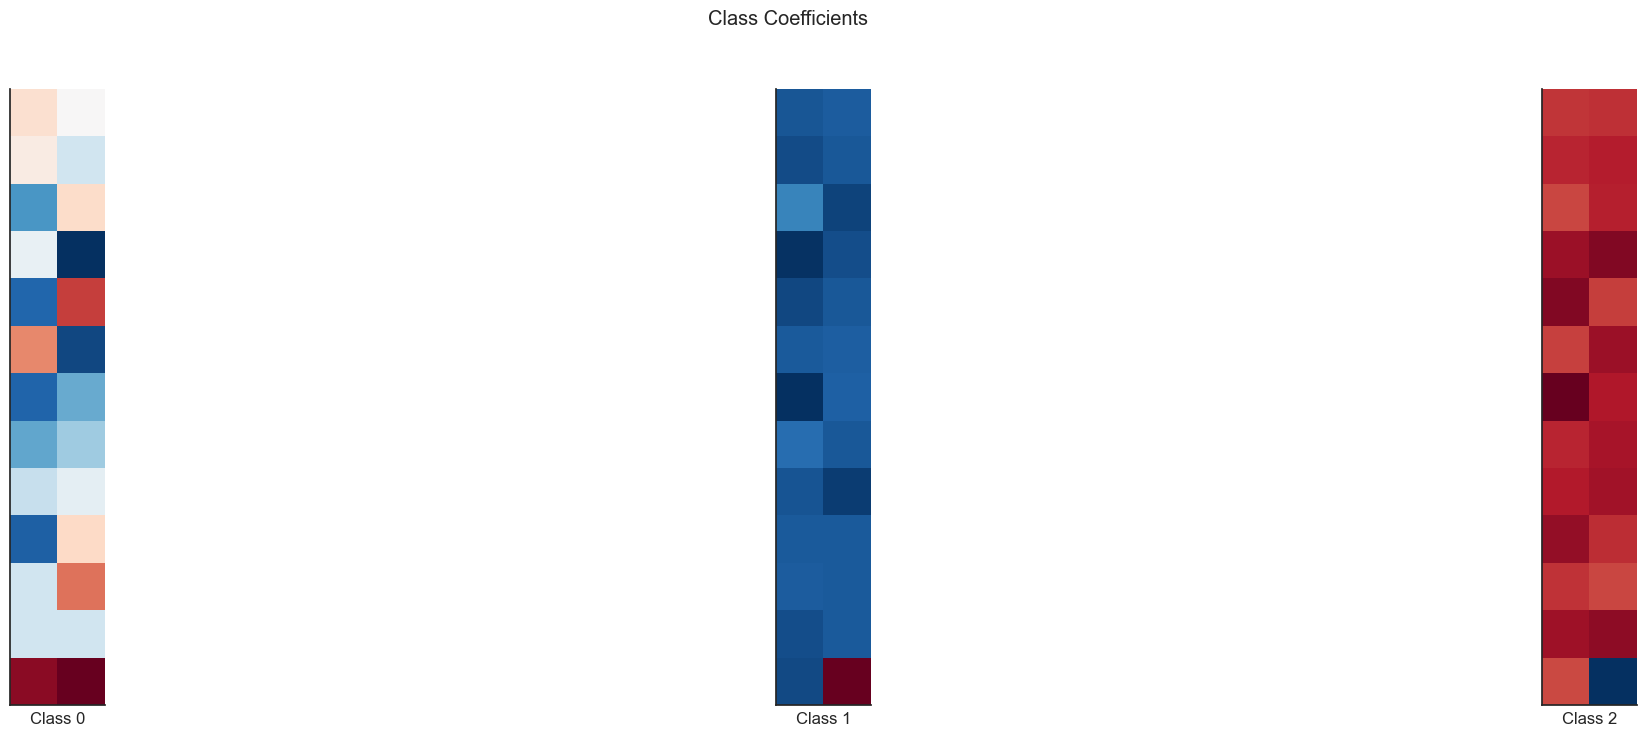

In [168]:
plt.subplots(1,3, figsize=(28,8))
for i in range(3):
    l1 = plt.subplot(1, 3, i + 1)
    l1.imshow(svm_coef[i].reshape(13, 2), cmap=plt.cm.RdBu)
    l1.set_xticks(())
    l1.set_yticks(())
    l1.set_xlabel('Class %i' % i)
plt.suptitle('Class Coefficients')
plt.show()

### Running SVC RBF for multiple cost factors (c) and Gamma


In [169]:
coefficient = []
n_supp = []
sup_vec = []
i = 0
df_svc = df_training.copy()
df_svc = pd.DataFrame(columns = ['c','gamma','train_acc','test_acc'])
for c in [0.01, 0.1, 1, 10]:
    for g in [0.01, 0.1, 1, 10, 100]:
        svm = SVC(kernel='rbf', C=c, gamma=g)
        model = svm.fit(X_train, y_train)
        globals()['model%s' % i] = model
        d_coef = svm.dual_coef_
        support = svm.n_support_
        sv = svm.support_

        p_tr = svm.predict(X_train)
        a_tr = accuracy_score(y_train, p_tr)

        pred = svm.predict(X_test)
        a = accuracy_score(y_test, pred)

        coefficient.append(d_coef)
        n_supp.append(support)
        sup_vec.append(sv)
        df_svc.loc[i] = [c,g,a_tr,a]
        i=i+1
df_svc

,c,gamma,train_acc,test_acc
0,0.01,0.01,0.564061,0.545603
1,0.01,0.10,0.579805,0.561889
2,0.01,1.00,0.418024,0.418567
3,0.01,10.00,0.418024,0.418567
4,0.01,100.00,0.418024,0.418567
5,0.10,0.01,0.710641,0.700326
6,0.10,0.10,0.834962,0.833876
7,0.10,1.00,0.620521,0.607492
8,0.10,10.00,0.460369,0.447883
9,0.10,100.00,0.431053,0.426710


### Based on these results, we choose C as 10.00 and Gamma as 0.10
### SVC RBF = 96.90%

### SVC Poly Kernel


In [170]:
coefficient = []
n_supp = []
sup_vec = []
i = 0
df_svc = pd.DataFrame(columns = ['c','degree','train_acc','test_acc'])
for c in [0.01, 0.1, 1, 10, 100]:
    for d in [2,3,4,5]:
        svm = SVC(kernel='poly', C=c, degree=d)
        model = svm.fit(X_train, y_train)
        globals()['model%s' % i] = model
        d_coef = svm.dual_coef_
        support = svm.n_support_
        sv = svm.support_

        p_tr = svm.predict(X_train)
        a_tr = accuracy_score(y_train, p_tr)

        pred = svm.predict(X_test)
        a = accuracy_score(y_test, pred)

        coefficient.append(d_coef)
        n_supp.append(support)
        sup_vec.append(sv)
        df_svc.loc[i] = [c,d,a_tr,a]
        i=i+1

df_svc

,c,degree,train_acc,test_acc
0,0.01,2.0,0.533116,0.511401
1,0.01,3.0,0.541260,0.513029
2,0.01,4.0,0.565147,0.537459
3,0.01,5.0,0.605320,0.561889
4,0.10,2.0,0.669924,0.675896
5,0.10,3.0,0.694354,0.706840
6,0.10,4.0,0.701412,0.705212
7,0.10,5.0,0.710641,0.690554
8,1.00,2.0,0.808903,0.811075
9,1.00,3.0,0.821933,0.806189


### We choose C=100 and Gamma=2.0
### SVC Poly Kernel = 92.4%

In [171]:
pd.DataFrame(coefficient[10]) 


,0,1,2,3,4,5,6,7,8,9,...,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077
0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-1.0,-1.0,-0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


**To Summarize the Model Performance (test accuracy):**
*   Linear SVC (best performance): 81 %
*   SVC rbf (best performance): 96.9 %
*   SVC poly (best performance): 92.4 %

**It is clear that SVM with 'rbf' kernel gives the best result among all these models.**

### PCA -  PCA is sensible to the variations of the scale of charactheristics, so we're going to standardize the data to have a zero average and a unitary variance.

In [172]:
df_training_std = df_training.copy().drop('classe', axis=1)
df_testing_std = df_testing.copy().drop('classe', axis=1)

columns_to_standardize = df_training_std.columns

scaler = StandardScaler()

df_training_std[columns_to_standardize] = scaler.fit_transform(df_training_std[columns_to_standardize])
df_testing_std[columns_to_standardize] = scaler.transform(df_testing_std[columns_to_standardize])

pca = PCA(n_components=0.95)  # Keep 95% of variance
pca.fit(df_training_std)

df_training_pca = pca.transform(df_training_std)
df_testing_pca = pca.transform(df_testing_std)

model = LogisticRegression()
model.fit(df_training_pca, y_train)

y_pred = model.predict(df_testing_pca)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

absolute_loading_scores = np.abs(pca.components_)

mean_loading_scores = absolute_loading_scores.mean(axis=0)

mean_loading_df = pd.DataFrame(mean_loading_scores, index=df_training_std.columns, columns=['Mean Loading Score'])

sorted_features = mean_loading_df.sort_values(by='Mean Loading Score', ascending=False)

print(sorted_features)


Accuracy: 0.8013029315960912
Classification Report:
                precision    recall  f1-score   support

     car_horn       0.75      0.67      0.71       107
engine_idling       0.82      0.84      0.83       250
 street_music       0.80      0.81      0.81       257

     accuracy                           0.80       614
    macro avg       0.79      0.78      0.78       614
 weighted avg       0.80      0.80      0.80       614

          Mean Loading Score
desvio11            0.182400
desvio2             0.180543
desvio3             0.179755
desvio5             0.178822
media8              0.174852
media3              0.174796
desvio8             0.174220
media2              0.169376
desvio12            0.168160
desvio6             0.165808
media12             0.164769
media9              0.164125
media6              0.164003
media5              0.162912
desvio10            0.159972
media7              0.157968
media4              0.151369
media11             0.149615
desvio7 

### PCA Results:

**Accuracy:** 0.8013029315960912

**Mean Loading Score:**
- desvio11: 0.182400
- desvio2: 0.180543
- desvio3: 0.179755
- desvio5: 0.178822
- media8: 0.174852
- media3: 0.174796
- desvio8: 0.174220
- media2: 0.169376
- desvio12: 0.168160
- desvio6: 0.165808
- media12: 0.164769
- media9: 0.164125
- media6: 0.164003
- media5: 0.162912
- desvio10: 0.159972
- media7: 0.157968
- media4: 0.151369
- media11: 0.149615
- desvio7: 0.149369
- media10: 0.149004
- desvio9: 0.146514
- desvio4: 0.140499
- desvio1: 0.131651
- media1: 0.129765
- media0: 0.111959
- desvio0: 0.106321

#### Upon obtaining these results, we observe that *desvio11* regains relevance and reappears at the top of the correlation list based on the loading score. Although it loses some "positions," *desvio12* continues to demonstrate its significance, considering that the loading score is not considerably different from that of *desvio11*, and the same logic is visible between *desvio12* and *media5*.

When compared with the results obtained in step 4, we can see that, in comparison to Lasso, the most important feature is the same (*desvio11*). Consequently, when compared to Ridge, considering that for the latter model *desvio11* appears as the 2nd most relevant feature, we can conclude that PCA achieved similar results regarding the most important feature and slightly different (although not significantly relevant) results concerning different features. In other words, the order of importance changes slightly, giving a sense that the models agree on the most important feature and "generally" on those they consider more important, alternating their positions between models.

Regarding the accuracy of the models, all of them achieve very comparable results, with Lasso obtaining a slightly higher value (almost 0.1).
